#Image segmentation on waterfall plots
\
The following code aims to apply the image segmentation problem to the waterfall plots of a wireless channel.
<br>
Image segmentation is the process to partition a digital image into multiple segments; in this case the code aims to find the portions of the spectrum where a jammer is doing its disturbing activity.
<br>
The dataset in this problem consisted in a collection of waterfall plots (PSD diagrams over time) in which at the end the action of a gaussian noise jammer was applied.
<br>
The model is an autoencoder, trained only trained using the trusted cases (so the empty channel or the case in which there is transmission of some data). The model then tries to reconstruct the input, but being trained only with the trusted cases it will reconstruct with higher MSE the jammed plots.
<br>
The image segmentation goal then is performed by setting a threshold, and classify as anomaly the pixels (or element of a matrix) in which the reconstruction error is higher than that value.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

import gc

In [2]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#downloading the dataset 
url = "https://drive.google.com/u/0/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download"
output = "matrixes.zip"
gdown.download(url, output)
!unzip matrixes.zip


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download
From (redirected): https://drive.google.com/uc?id=1R_TMHz6tT-rfScMsjxnIQSaG4orX5jQV&export=download&confirm=t&uuid=dc0b4b34-2b70-49c8-84a6-022acb5ce56b
To: /content/matrixes.zip
100%|██████████| 2.72G/2.72G [00:34<00:00, 79.4MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: matrixes/clean/0_8.npy  
  inflating: matrixes/clean/0_10.npy  
  inflating: matrixes/clean/0_16.npy  
  inflating: matrixes/clean/0_24.npy  
  inflating: matrixes/clean/0_28.npy  
  inflating: matrixes/clean/0_38.npy  
  inflating: matrixes/clean/0_40.npy  
  inflating: matrixes/clean/0_42.npy  
  inflating: matrixes/clean/0_48.npy  
  inflating: matrixes/clean/0_62.npy  
  inflating: matrixes/clean/0_70.npy  
  inflating: matrixes/clean/0_72.npy  
  inflating: matrixes/clean/0_78.npy  
  inflating: matrixes/clean/0_80.npy  
  inflating: matrixes/clean/0_83.npy  
  inflating: matrixes/clean/0_87.npy  
  inflating: matrixes/clean/0_88.npy  
  inflating: matrixes/clean/0_93.npy  
  inflating: matrixes/clean/0_104.npy  
  inflating: matrixes/clean/0_105.npy  
  inflating: matrixes/clean/0_106.npy  
  inflating: matrixes/clean/0_107.npy  
  inflating: matrixes/clean/0_114.npy  
  inflating: matrixes/clean/0_116.npy  
  inflati

In [4]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [5]:
clean = []
labels_clean =[]
val = []
labels_val =[]
anomalies = []
labels_anomalies =[]
test=[]
labels_test=[]
## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
for folder in tqdm(os.listdir("matrixes")):
    print(folder)
    for mat in tqdm(os.listdir("matrixes/"+folder+"/")):
        if folder == "clean":
            clean.append(np.load("matrixes/"+folder+"/"+mat))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(np.load("matrixes/"+folder+"/"+mat))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(np.load("matrixes/"+folder+"/"+mat))
            labels_anomalies.append(1)
        else:
          test.append(np.load("matrixes/"+folder+"/"+mat))
          labels_test.append(mapping[int(mat[0])])
                   

  0%|          | 0/4 [00:00<?, ?it/s]

jammed_channel



 25%|██▌       | 1/4 [00:00<00:01,  2.48it/s]

clean_validation



 50%|█████     | 2/4 [00:01<00:01,  1.27it/s]

test



 75%|███████▌  | 3/4 [00:01<00:00,  1.54it/s]

clean



100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


During the execution of the code a problem was found: the low energy levels present for example in the sidebands of the channels (10^-14) made difficult to train in an optimal way the neural network, because even after 1000 epochs of training the MSE of the reconstruction was in the order of magnitude of 10^-11, so 1000 more than the some energy levels in the trusted cases, making so the ratio between the reconstruction error of the anomalies and the trusted cases very close to the number 1.
<br>
The problem was solved by applying to each element of the matrix the -log function, which is a monotonic function.

In [6]:
clean = -np.log(np.array(clean)) 
np.save("clean.npy",clean)
del clean
gc.collect()


val = -np.log(np.array(val))
np.save("val.npy",val)
del val
gc.collect()


anomalies = -np.log(np.array(anomalies))
np.save("anomalies.npy",anomalies)
del anomalies
gc.collect()

test=-np.log(np.array(test))
np.save("test.npy", test)
del test
gc.collect()

labels_test=np.array(labels_test)
np.save("labels_test.npy",labels_test)
del labels_test
gc.collect()

## load the datasets in the memory and not in the RAM in order to reduce space complexity

0

In [7]:
clean = np.load("clean.npy",allow_pickle = True, mmap_mode="r")
val = np.load("val.npy",allow_pickle = True, mmap_mode="r")
anomalies = np.load("anomalies.npy",allow_pickle = True, mmap_mode="r")
test = np.load("test.npy",allow_pickle = True, mmap_mode="r")
labels_test=np.load("labels_test.npy",allow_pickle = True, mmap_mode="r")

In [8]:
type(val) ## check

numpy.memmap

The matrixes present in the dataset are waterfall plots. Each column of the matrix reperesent a frequency and each row represent a timestamp.
<br>
In this case to reduce the computational complexity of the problem the waterfall plots are composed by 50 PSDs, with the axis of time that starts in the first row of the matrix and increases with the increasing of the row index.

In [9]:
clean[60].shape ## test only to see if i have an image with the correct size

(50, 1024)

In [10]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(16, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU(), input_shape=(50,1024,1)),
            Conv2D(32, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2D(64, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2D(128, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Flatten(),
            Dense(32, activation = keras.layers.LeakyReLU()),
        ])
        self.decoder = Sequential([                            
            Dense(2*63*128, activation=keras.layers.LeakyReLU(),input_shape=self.encoder.output.shape[1:]),
            Reshape((2,63,128)),
            Conv2DTranspose(64, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2DTranspose(32, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            Conv2DTranspose(16, 3, strides=2, padding="valid", activation=keras.layers.LeakyReLU()),
            keras.layers.ZeroPadding2D(padding=((1,1),(1,0))),
            Conv2DTranspose(1, 3, strides=2, padding="same", activation=keras.layers.LeakyReLU()),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
model = AutoEncoder()

model.compile(tf.keras.optimizers.Adam(weight_decay=1e-7), loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 511, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 255, 32)       4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 127, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 63, 128)        73856     
                                                                 
 flatten (Flatten)           (None, 16128)             0         
                                                                 
 dense (Dense)               (None, 32)                516128    
                                                                 
Total params: 613,280
Trainable params: 613,280
Non-trai

Printing encoder model:



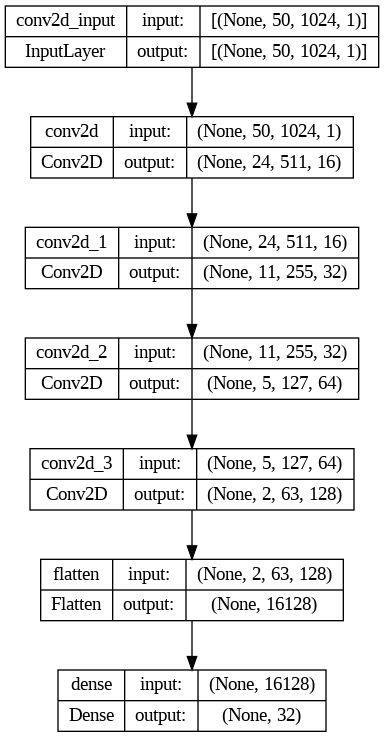

In [ ]:
print("Printing encoder model:\n")
tf.keras.utils.plot_model(
    model.encoder,
    to_file="model_encoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

Printing decoder model:



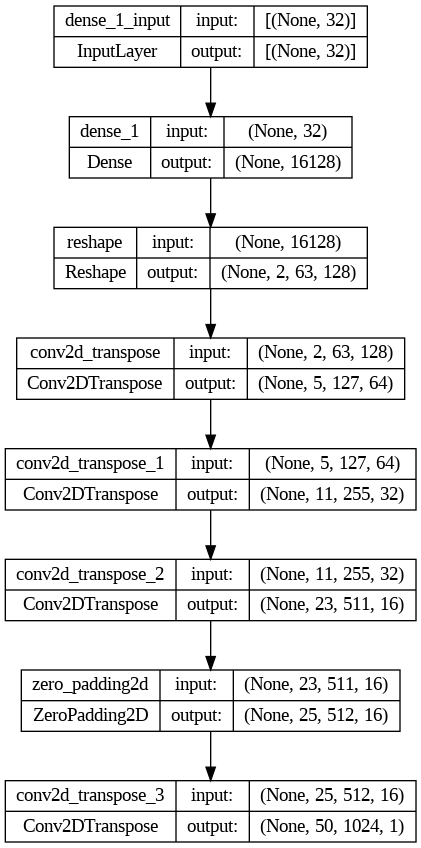

In [ ]:
print("Printing decoder model:\n")
tf.keras.utils.plot_model(
    model.decoder,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) ## train the network and stop with a patience of 6 monitoring the validation loss
history=model.fit(
        x=clean,
        y=clean,
        batch_size=32,
        epochs=500,
        callbacks=[callback],
        verbose=True,
        validation_data=(val,val), 
        shuffle=True,
    )

Epoch 1/500
125/125 [==============================] - 24s 66ms/step - loss: 92.6588 - val_loss: 42.7934
Epoch 2/500
125/125 [==============================] - 3s 26ms/step - loss: 42.2439 - val_loss: 42.2630
Epoch 3/500
125/125 [==============================] - 3s 26ms/step - loss: 42.0880 - val_loss: 42.5858
Epoch 4/500
125/125 [==============================] - 5s 36ms/step - loss: 41.3997 - val_loss: 41.5217
Epoch 5/500
125/125 [==============================] - 3s 28ms/step - loss: 41.3382 - val_loss: 41.5065
Epoch 6/500
125/125 [==============================] - 3s 26ms/step - loss: 41.1076 - val_loss: 40.8633
Epoch 7/500
125/125 [==============================] - 3s 26ms/step - loss: 40.6101 - val_loss: 41.1836
Epoch 8/500
125/125 [==============================] - 4s 28ms/step - loss: 40.4333 - val_loss: 40.1979
Epoch 9/500
125/125 [==============================] - 3s 26ms/step - loss: 47.2477 - val_loss: 39.8326
Epoch 10/500
125/125 [==============================] - 3s 26ms

In [ ]:
model.save("AUTOENCODER_model")

np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

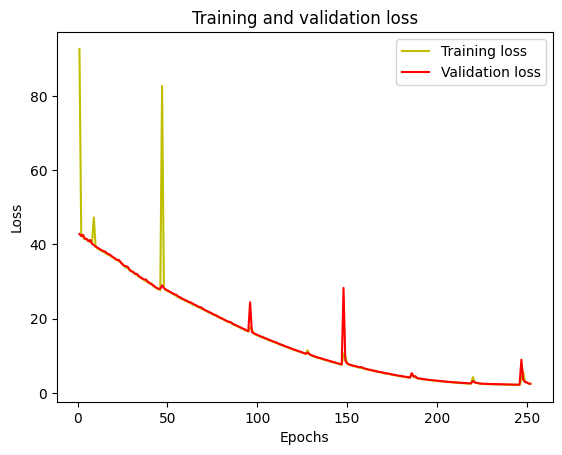

In [13]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
validation_error = model.evaluate(val,val)
anomaly_error = model.evaluate(anomalies,anomalies)
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

19/19 [==============================] - 1s 58ms/step - loss: 17.5304
Validation error 2.4746248722076416
Anomaly error 17.530420303344727
The reconstruction error of the jammed channel is  7.084071812349334  more than the clean channel


In [16]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,50,1024,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    maximum= max(recon_error_list) 
    minimum= min(recon_error_list)
    
    return average_recon_error, stdev_recon_error, maximum, minimum

In [17]:
normal_values = calc_recon_error(val)
jammed_values = calc_recon_error(anomalies)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 [==============================] - 1s 672ms/step - loss: 2.5467


  0%|          | 1/1600 [00:01<26:54,  1.01s/it]

1/1 [==============================] - 0s 46ms/step - loss: 2.4782


  0%|          | 3/1600 [00:01<08:33,  3.11it/s]

1/1 [==============================] - 0s 45ms/step - loss: 5.4299


  0%|          | 4/1600 [00:01<06:36,  4.02it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.9918


  0%|          | 5/1600 [00:01<05:18,  5.00it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1545


  0%|          | 7/1600 [00:01<03:56,  6.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.5752


  1%|          | 9/1600 [00:01<03:23,  7.82it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.4961


  1%|          | 10/1600 [00:01<03:27,  7.65it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1030


  1%|          | 11/1600 [00:02<03:16,  8.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4108


  1%|          | 13/1600 [00:02<02:56,  8.97it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.5561


  1%|          | 15/1600 [00:02<02:46,  9.51it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.7349


  1%|          | 16/1600 [00:02<02:46,  9.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0867


  1%|          | 17/1600 [00:02<02:45,  9.58it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4643


  1%|          | 18/1600 [00:02<02:49,  9.33it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.9152


  1%|▏         | 20/1600 [00:02<02:38,  9.94it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.4884


  1%|▏         | 21/1600 [00:03<02:43,  9.68it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.7815


  1%|▏         | 22/1600 [00:03<02:48,  9.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.8888


  1%|▏         | 23/1600 [00:03<02:46,  9.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 3.3304


  2%|▏         | 24/1600 [00:03<02:50,  9.25it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.7556


  2%|▏         | 25/1600 [00:03<02:49,  9.27it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.0978


  2%|▏         | 26/1600 [00:03<02:54,  9.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1272


  2%|▏         | 28/1600 [00:03<02:30, 10.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1148


  2%|▏         | 30/1600 [00:03<02:19, 11.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1356


  2%|▏         | 32/1600 [00:04<02:13, 11.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1221


  2%|▏         | 34/1600 [00:04<02:10, 12.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.4575


  2%|▏         | 36/1600 [00:04<02:04, 12.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6441


  2%|▏         | 38/1600 [00:04<01:56, 13.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1288


  2%|▎         | 40/1600 [00:04<01:57, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0959


  3%|▎         | 42/1600 [00:04<01:58, 13.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6344


  3%|▎         | 44/1600 [00:04<02:00, 12.94it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7075


  3%|▎         | 46/1600 [00:05<01:59, 13.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6023


  3%|▎         | 48/1600 [00:05<01:56, 13.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1097


  3%|▎         | 50/1600 [00:05<01:56, 13.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0569


  3%|▎         | 52/1600 [00:05<01:53, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.0499


  3%|▎         | 54/1600 [00:05<01:52, 13.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1360


  4%|▎         | 56/1600 [00:05<01:50, 14.00it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1034


  4%|▎         | 58/1600 [00:05<01:49, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1795


  4%|▍         | 60/1600 [00:06<01:49, 14.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1841


  4%|▍         | 62/1600 [00:06<01:49, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 4.9366


  4%|▍         | 64/1600 [00:06<01:50, 13.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.3098


  4%|▍         | 66/1600 [00:06<01:47, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1102


  4%|▍         | 68/1600 [00:06<01:45, 14.53it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0925


  4%|▍         | 70/1600 [00:06<01:42, 14.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4608


  4%|▍         | 72/1600 [00:06<01:48, 14.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1113


  5%|▍         | 74/1600 [00:07<01:52, 13.62it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.9625


  5%|▍         | 76/1600 [00:07<01:52, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0717


  5%|▍         | 78/1600 [00:07<01:54, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1578


  5%|▌         | 80/1600 [00:07<01:55, 13.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0697


  5%|▌         | 82/1600 [00:07<01:55, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1041


  5%|▌         | 84/1600 [00:07<01:55, 13.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.3557


  5%|▌         | 86/1600 [00:07<01:55, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2562


  6%|▌         | 88/1600 [00:08<01:56, 13.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0928


  6%|▌         | 90/1600 [00:08<01:58, 12.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1123


  6%|▌         | 92/1600 [00:08<02:01, 12.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5045


  6%|▌         | 94/1600 [00:08<01:56, 12.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1177


  6%|▌         | 96/1600 [00:08<01:54, 13.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2950


  6%|▌         | 98/1600 [00:08<01:53, 13.22it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0930


  6%|▋         | 100/1600 [00:09<01:53, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1659


  6%|▋         | 102/1600 [00:09<01:54, 13.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2116


  6%|▋         | 104/1600 [00:09<01:53, 13.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1387


  7%|▋         | 106/1600 [00:09<01:49, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0996


  7%|▋         | 108/1600 [00:09<01:46, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0842


  7%|▋         | 110/1600 [00:09<01:48, 13.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0687


  7%|▋         | 112/1600 [00:09<01:46, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1247


  7%|▋         | 114/1600 [00:10<01:47, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 5.0081


  7%|▋         | 116/1600 [00:10<01:52, 13.24it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0874


  7%|▋         | 118/1600 [00:10<01:52, 13.15it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8580


  8%|▊         | 120/1600 [00:10<01:55, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1179


  8%|▊         | 122/1600 [00:10<01:56, 12.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2741


  8%|▊         | 124/1600 [00:10<01:53, 12.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5454


  8%|▊         | 126/1600 [00:11<01:53, 12.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0795


  8%|▊         | 128/1600 [00:11<01:54, 12.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0697


  8%|▊         | 130/1600 [00:11<01:51, 13.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1663


  8%|▊         | 132/1600 [00:11<01:54, 12.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0943


  8%|▊         | 134/1600 [00:11<01:53, 12.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1135


  8%|▊         | 136/1600 [00:11<01:51, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1282


  9%|▊         | 138/1600 [00:11<01:54, 12.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1306


  9%|▉         | 140/1600 [00:12<01:51, 13.09it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0360


  9%|▉         | 142/1600 [00:12<01:50, 13.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1447


  9%|▉         | 144/1600 [00:12<01:50, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.7092


  9%|▉         | 146/1600 [00:12<01:51, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 4.1578


  9%|▉         | 148/1600 [00:12<01:54, 12.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1138


  9%|▉         | 150/1600 [00:12<01:56, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1000


 10%|▉         | 152/1600 [00:13<01:54, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6031


 10%|▉         | 154/1600 [00:13<01:54, 12.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0990


 10%|▉         | 156/1600 [00:13<01:57, 12.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5824


 10%|▉         | 158/1600 [00:13<01:59, 12.07it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.0751


 10%|█         | 160/1600 [00:13<02:04, 11.61it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.3438


 10%|█         | 162/1600 [00:13<02:11, 10.96it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.4284


 10%|█         | 164/1600 [00:14<02:18, 10.35it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1511


 10%|█         | 166/1600 [00:14<02:17, 10.45it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.4997


 10%|█         | 168/1600 [00:14<02:20, 10.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0920


 11%|█         | 170/1600 [00:14<02:18, 10.29it/s]

1/1 [==============================] - 0s 119ms/step - loss: 2.0692


 11%|█         | 172/1600 [00:15<03:13,  7.39it/s]

1/1 [==============================] - 0s 87ms/step - loss: 2.1208


 11%|█         | 173/1600 [00:15<03:41,  6.46it/s]

1/1 [==============================] - 0s 111ms/step - loss: 2.1050


 11%|█         | 174/1600 [00:15<04:16,  5.56it/s]

1/1 [==============================] - 0s 90ms/step - loss: 2.0841


 11%|█         | 175/1600 [00:15<04:40,  5.08it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.8943


 11%|█         | 176/1600 [00:16<04:58,  4.78it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.1006


 11%|█         | 177/1600 [00:16<04:36,  5.14it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.1098


 11%|█         | 178/1600 [00:16<04:19,  5.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.9576


 11%|█▏        | 180/1600 [00:16<03:16,  7.24it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.1187


 11%|█▏        | 181/1600 [00:16<03:10,  7.45it/s]

1/1 [==============================] - 0s 41ms/step - loss: 4.7854


 11%|█▏        | 182/1600 [00:16<03:03,  7.73it/s]

1/1 [==============================] - 0s 59ms/step - loss: 2.1741


 11%|█▏        | 183/1600 [00:17<03:17,  7.17it/s]

1/1 [==============================] - 0s 98ms/step - loss: 2.1246


 12%|█▏        | 184/1600 [00:17<04:18,  5.49it/s]

1/1 [==============================] - 0s 61ms/step - loss: 2.1350


 12%|█▏        | 185/1600 [00:17<04:05,  5.76it/s]

1/1 [==============================] - 0s 61ms/step - loss: 2.1201


 12%|█▏        | 186/1600 [00:17<03:58,  5.93it/s]

1/1 [==============================] - 0s 116ms/step - loss: 2.1439


 12%|█▏        | 187/1600 [00:18<05:06,  4.62it/s]

1/1 [==============================] - 0s 91ms/step - loss: 2.1361


 12%|█▏        | 188/1600 [00:18<05:34,  4.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0803


 12%|█▏        | 189/1600 [00:18<04:55,  4.78it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0912


 12%|█▏        | 191/1600 [00:18<03:31,  6.65it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.1132


 12%|█▏        | 193/1600 [00:18<02:53,  8.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0027


 12%|█▏        | 195/1600 [00:18<02:30,  9.34it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3004


 12%|█▏        | 197/1600 [00:19<02:17, 10.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3960


 12%|█▏        | 199/1600 [00:19<02:07, 11.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.8203


 13%|█▎        | 201/1600 [00:19<01:58, 11.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.2072


 13%|█▎        | 203/1600 [00:19<01:55, 12.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0947


 13%|█▎        | 205/1600 [00:19<01:56, 12.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0899


 13%|█▎        | 207/1600 [00:19<01:52, 12.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1094


 13%|█▎        | 209/1600 [00:20<01:47, 12.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1113


 13%|█▎        | 211/1600 [00:20<01:45, 13.16it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6827


 13%|█▎        | 213/1600 [00:20<01:44, 13.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0826


 13%|█▎        | 215/1600 [00:20<01:44, 13.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5101


 14%|█▎        | 217/1600 [00:20<01:45, 13.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 5.3058


 14%|█▎        | 219/1600 [00:20<01:42, 13.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1229


 14%|█▍        | 221/1600 [00:20<01:41, 13.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1439


 14%|█▍        | 223/1600 [00:21<01:44, 13.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4339


 14%|█▍        | 225/1600 [00:21<01:44, 13.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0867


 14%|█▍        | 227/1600 [00:21<01:43, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1467


 14%|█▍        | 229/1600 [00:21<01:45, 13.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1480


 14%|█▍        | 231/1600 [00:21<01:47, 12.73it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.1365


 15%|█▍        | 233/1600 [00:21<01:44, 13.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 4.1542


 15%|█▍        | 235/1600 [00:21<01:43, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2557


 15%|█▍        | 237/1600 [00:22<01:41, 13.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0942


 15%|█▍        | 239/1600 [00:22<01:44, 12.98it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1011


 15%|█▌        | 241/1600 [00:22<01:44, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0138


 15%|█▌        | 243/1600 [00:22<01:43, 13.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1011


 15%|█▌        | 245/1600 [00:22<01:42, 13.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1415


 15%|█▌        | 247/1600 [00:22<01:40, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0036


 16%|█▌        | 249/1600 [00:23<01:39, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.2068


 16%|█▌        | 251/1600 [00:23<01:38, 13.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1361


 16%|█▌        | 253/1600 [00:23<01:37, 13.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1517


 16%|█▌        | 255/1600 [00:23<01:38, 13.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.0798


 16%|█▌        | 257/1600 [00:23<01:41, 13.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1361


 16%|█▌        | 259/1600 [00:23<01:47, 12.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1032


 16%|█▋        | 261/1600 [00:23<01:47, 12.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1074


 16%|█▋        | 263/1600 [00:24<01:48, 12.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1365


 17%|█▋        | 265/1600 [00:24<01:46, 12.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.2897


 17%|█▋        | 267/1600 [00:24<01:44, 12.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1171


 17%|█▋        | 269/1600 [00:24<01:43, 12.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0971


 17%|█▋        | 271/1600 [00:24<01:48, 12.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1021


 17%|█▋        | 273/1600 [00:24<01:45, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2701


 17%|█▋        | 275/1600 [00:25<01:44, 12.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1186


 17%|█▋        | 277/1600 [00:25<01:41, 13.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1137


 17%|█▋        | 279/1600 [00:25<01:41, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0177


 18%|█▊        | 281/1600 [00:25<01:42, 12.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3443


 18%|█▊        | 283/1600 [00:25<01:40, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4306


 18%|█▊        | 285/1600 [00:25<01:38, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3127


 18%|█▊        | 287/1600 [00:25<01:38, 13.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1012


 18%|█▊        | 289/1600 [00:26<01:38, 13.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1027


 18%|█▊        | 291/1600 [00:26<01:38, 13.28it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1207


 18%|█▊        | 293/1600 [00:26<01:50, 11.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.7191


 18%|█▊        | 295/1600 [00:26<01:58, 11.04it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.3741


 19%|█▊        | 297/1600 [00:26<02:03, 10.55it/s]

1/1 [==============================] - 0s 45ms/step - loss: 4.3267


 19%|█▊        | 299/1600 [00:27<02:14,  9.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0186


 19%|█▉        | 300/1600 [00:27<02:13,  9.71it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.9965


 19%|█▉        | 302/1600 [00:27<02:13,  9.75it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1042


 19%|█▉        | 303/1600 [00:27<02:13,  9.71it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1570


 19%|█▉        | 304/1600 [00:27<02:14,  9.62it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1338


 19%|█▉        | 306/1600 [00:27<02:15,  9.53it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0982


 19%|█▉        | 307/1600 [00:27<02:14,  9.62it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.5316


 19%|█▉        | 308/1600 [00:28<02:14,  9.63it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.4450


 19%|█▉        | 309/1600 [00:28<02:16,  9.44it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1622


 19%|█▉        | 310/1600 [00:28<02:21,  9.14it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1101


 19%|█▉        | 311/1600 [00:28<02:23,  8.99it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1217


 20%|█▉        | 312/1600 [00:28<02:20,  9.17it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1098


 20%|█▉        | 313/1600 [00:28<02:17,  9.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.2387


 20%|█▉        | 315/1600 [00:28<02:05, 10.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0892


 20%|█▉        | 317/1600 [00:28<01:57, 10.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0898


 20%|█▉        | 319/1600 [00:29<01:54, 11.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1603


 20%|██        | 321/1600 [00:29<01:50, 11.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1119


 20%|██        | 323/1600 [00:29<01:45, 12.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1080


 20%|██        | 325/1600 [00:29<01:44, 12.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0968


 20%|██        | 327/1600 [00:29<01:46, 11.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 5.9018


 21%|██        | 329/1600 [00:29<01:46, 11.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1069


 21%|██        | 331/1600 [00:30<01:46, 11.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6530


 21%|██        | 333/1600 [00:30<01:46, 11.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1157


 21%|██        | 335/1600 [00:30<01:46, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.3070


 21%|██        | 337/1600 [00:30<01:44, 12.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3409


 21%|██        | 339/1600 [00:30<01:42, 12.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1172


 21%|██▏       | 341/1600 [00:30<01:43, 12.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7896


 21%|██▏       | 343/1600 [00:31<01:48, 11.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.0022


 22%|██▏       | 345/1600 [00:31<01:45, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9910


 22%|██▏       | 347/1600 [00:31<01:42, 12.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1057


 22%|██▏       | 349/1600 [00:31<01:39, 12.51it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1253


 22%|██▏       | 351/1600 [00:31<01:43, 12.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1160


 22%|██▏       | 353/1600 [00:31<01:43, 12.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.0919


 22%|██▏       | 355/1600 [00:32<01:42, 12.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1261


 22%|██▏       | 357/1600 [00:32<01:41, 12.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1122


 22%|██▏       | 359/1600 [00:32<01:43, 12.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7938


 23%|██▎       | 361/1600 [00:32<01:43, 12.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7121


 23%|██▎       | 363/1600 [00:32<01:41, 12.22it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1340


 23%|██▎       | 365/1600 [00:32<01:40, 12.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0820


 23%|██▎       | 367/1600 [00:33<01:41, 12.16it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.3116


 23%|██▎       | 369/1600 [00:33<01:40, 12.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0971


 23%|██▎       | 371/1600 [00:33<01:39, 12.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1354


 23%|██▎       | 373/1600 [00:33<01:39, 12.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1223


 23%|██▎       | 375/1600 [00:33<01:38, 12.41it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.5474


 24%|██▎       | 377/1600 [00:34<02:58,  6.85it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1147


 24%|██▎       | 379/1600 [00:34<02:40,  7.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1100


 24%|██▍       | 381/1600 [00:34<02:23,  8.47it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.0175


 24%|██▍       | 383/1600 [00:34<02:15,  9.01it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.5463


 24%|██▍       | 385/1600 [00:35<02:13,  9.13it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.3744


 24%|██▍       | 387/1600 [00:35<02:07,  9.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1047


 24%|██▍       | 389/1600 [00:35<01:58, 10.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1319


 24%|██▍       | 391/1600 [00:35<01:55, 10.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.4794


 25%|██▍       | 393/1600 [00:35<01:55, 10.43it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0681


 25%|██▍       | 395/1600 [00:36<01:54, 10.53it/s]

1/1 [==============================] - 0s 37ms/step - loss: 3.8691


 25%|██▍       | 397/1600 [00:36<01:52, 10.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1287


 25%|██▍       | 399/1600 [00:36<01:49, 10.95it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1712


 25%|██▌       | 401/1600 [00:36<01:49, 11.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1091


 25%|██▌       | 403/1600 [00:36<01:46, 11.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1382


 25%|██▌       | 405/1600 [00:36<01:45, 11.38it/s]

1/1 [==============================] - 0s 34ms/step - loss: 3.4570


 25%|██▌       | 407/1600 [00:37<01:44, 11.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0273


 26%|██▌       | 409/1600 [00:37<01:47, 11.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1051


 26%|██▌       | 411/1600 [00:37<01:44, 11.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6769


 26%|██▌       | 413/1600 [00:37<01:41, 11.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.7551


 26%|██▌       | 415/1600 [00:37<01:41, 11.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0844


 26%|██▌       | 417/1600 [00:37<01:43, 11.39it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2295


 26%|██▌       | 419/1600 [00:38<01:44, 11.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0160


 26%|██▋       | 421/1600 [00:38<01:42, 11.47it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4259


 26%|██▋       | 423/1600 [00:38<01:41, 11.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5466


 27%|██▋       | 425/1600 [00:38<01:41, 11.59it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1006


 27%|██▋       | 427/1600 [00:38<01:42, 11.48it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.2376


 27%|██▋       | 429/1600 [00:39<01:46, 11.04it/s]

1/1 [==============================] - 0s 39ms/step - loss: 6.9182


 27%|██▋       | 431/1600 [00:39<01:52, 10.35it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1297


 27%|██▋       | 433/1600 [00:39<01:55, 10.11it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0166


 27%|██▋       | 435/1600 [00:39<01:56, 10.02it/s]

1/1 [==============================] - 0s 39ms/step - loss: 5.7466


 27%|██▋       | 437/1600 [00:39<01:55, 10.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0961


 27%|██▋       | 439/1600 [00:40<01:55, 10.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1095


 28%|██▊       | 441/1600 [00:40<01:57,  9.87it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.7023


 28%|██▊       | 442/1600 [00:40<02:01,  9.52it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.3792


 28%|██▊       | 443/1600 [00:40<02:04,  9.30it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0457


 28%|██▊       | 444/1600 [00:40<02:04,  9.26it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.4135


 28%|██▊       | 445/1600 [00:40<02:06,  9.10it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.1080


 28%|██▊       | 446/1600 [00:40<02:08,  8.96it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.0190


 28%|██▊       | 447/1600 [00:40<02:08,  8.95it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1180


 28%|██▊       | 448/1600 [00:41<02:16,  8.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 3.2262


 28%|██▊       | 449/1600 [00:41<02:14,  8.53it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.1338


 28%|██▊       | 450/1600 [00:41<02:15,  8.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1223


 28%|██▊       | 452/1600 [00:41<01:55,  9.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5710


 28%|██▊       | 454/1600 [00:41<01:46, 10.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4211


 28%|██▊       | 456/1600 [00:41<01:42, 11.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0850


 29%|██▊       | 458/1600 [00:41<01:37, 11.73it/s]

1/1 [==============================] - 0s 26ms/step - loss: 5.9652


 29%|██▉       | 460/1600 [00:42<01:32, 12.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4154


 29%|██▉       | 462/1600 [00:42<01:38, 11.59it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1487


 29%|██▉       | 464/1600 [00:42<01:34, 12.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0745


 29%|██▉       | 466/1600 [00:42<01:33, 12.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0996


 29%|██▉       | 468/1600 [00:42<01:30, 12.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.7928


 29%|██▉       | 470/1600 [00:42<01:30, 12.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1214


 30%|██▉       | 472/1600 [00:43<01:28, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1214


 30%|██▉       | 474/1600 [00:43<01:30, 12.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1481


 30%|██▉       | 476/1600 [00:43<01:27, 12.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.9566


 30%|██▉       | 478/1600 [00:43<01:26, 12.94it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1101


 30%|███       | 480/1600 [00:43<01:28, 12.70it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.2649


 30%|███       | 482/1600 [00:43<01:28, 12.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1272


 30%|███       | 484/1600 [00:44<01:28, 12.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1050


 30%|███       | 486/1600 [00:44<01:26, 12.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.2078


 30%|███       | 488/1600 [00:44<01:29, 12.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0913


 31%|███       | 490/1600 [00:44<01:32, 12.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1474


 31%|███       | 492/1600 [00:44<01:32, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.8842


 31%|███       | 494/1600 [00:44<01:30, 12.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3578


 31%|███       | 496/1600 [00:45<01:30, 12.20it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.1119


 31%|███       | 498/1600 [00:45<01:32, 11.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0947


 31%|███▏      | 500/1600 [00:45<01:32, 11.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1695


 31%|███▏      | 502/1600 [00:45<01:30, 12.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6319


 32%|███▏      | 504/1600 [00:45<01:30, 12.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1358


 32%|███▏      | 506/1600 [00:45<01:31, 11.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1306


 32%|███▏      | 508/1600 [00:45<01:28, 12.30it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.5328


 32%|███▏      | 510/1600 [00:46<01:27, 12.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3394


 32%|███▏      | 512/1600 [00:46<01:27, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1216


 32%|███▏      | 514/1600 [00:46<01:26, 12.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1005


 32%|███▏      | 516/1600 [00:46<01:24, 12.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.0863


 32%|███▏      | 518/1600 [00:46<01:24, 12.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2937


 32%|███▎      | 520/1600 [00:46<01:24, 12.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0261


 33%|███▎      | 522/1600 [00:47<01:25, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0947


 33%|███▎      | 524/1600 [00:47<01:26, 12.43it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5041


 33%|███▎      | 526/1600 [00:47<01:27, 12.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3779


 33%|███▎      | 528/1600 [00:47<01:26, 12.40it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0721


 33%|███▎      | 530/1600 [00:47<01:29, 11.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1070


 33%|███▎      | 532/1600 [00:47<01:29, 12.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1812


 33%|███▎      | 534/1600 [00:48<01:28, 12.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1006


 34%|███▎      | 536/1600 [00:48<01:27, 12.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.0491


 34%|███▎      | 538/1600 [00:48<01:31, 11.61it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5671


 34%|███▍      | 540/1600 [00:48<01:29, 11.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1170


 34%|███▍      | 542/1600 [00:48<01:27, 12.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1569


 34%|███▍      | 544/1600 [00:48<01:25, 12.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1101


 34%|███▍      | 546/1600 [00:49<01:26, 12.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 4.6113


 34%|███▍      | 548/1600 [00:49<01:27, 12.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1545


 34%|███▍      | 550/1600 [00:49<01:30, 11.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2551


 34%|███▍      | 552/1600 [00:49<01:28, 11.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.5250


 35%|███▍      | 554/1600 [00:49<01:28, 11.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1398


 35%|███▍      | 556/1600 [00:49<01:28, 11.84it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0650


 35%|███▍      | 558/1600 [00:50<01:26, 12.00it/s]

1/1 [==============================] - 0s 167ms/step - loss: 2.1141


 35%|███▌      | 560/1600 [00:50<01:46,  9.79it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.0954


 35%|███▌      | 562/1600 [00:50<02:42,  6.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1018


 35%|███▌      | 563/1600 [00:51<02:35,  6.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1275


 35%|███▌      | 565/1600 [00:51<02:12,  7.81it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.6386


 35%|███▌      | 567/1600 [00:51<01:57,  8.79it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1127


 36%|███▌      | 569/1600 [00:51<01:52,  9.15it/s]

1/1 [==============================] - 0s 48ms/step - loss: 4.7859


 36%|███▌      | 571/1600 [00:51<01:59,  8.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 3.9170


 36%|███▌      | 572/1600 [00:51<01:57,  8.76it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1014


 36%|███▌      | 573/1600 [00:52<01:56,  8.83it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.6753


 36%|███▌      | 575/1600 [00:52<01:50,  9.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4070


 36%|███▌      | 576/1600 [00:52<01:48,  9.41it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.9063


 36%|███▌      | 577/1600 [00:52<01:52,  9.13it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2955


 36%|███▌      | 579/1600 [00:52<01:51,  9.15it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.2364


 36%|███▋      | 580/1600 [00:52<01:52,  9.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0012


 36%|███▋      | 581/1600 [00:52<01:53,  9.01it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.0253


 36%|███▋      | 582/1600 [00:53<01:51,  9.15it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1463


 36%|███▋      | 583/1600 [00:53<01:54,  8.91it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1226


 36%|███▋      | 584/1600 [00:53<01:58,  8.58it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.9897


 37%|███▋      | 585/1600 [00:53<01:54,  8.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1076


 37%|███▋      | 586/1600 [00:53<01:56,  8.70it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.0757


 37%|███▋      | 587/1600 [00:53<01:52,  9.01it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.0811


 37%|███▋      | 588/1600 [00:53<01:58,  8.55it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1361


 37%|███▋      | 589/1600 [00:53<01:55,  8.73it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.4909


 37%|███▋      | 590/1600 [00:54<02:09,  7.82it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1021


 37%|███▋      | 592/1600 [00:54<01:44,  9.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0998


 37%|███▋      | 594/1600 [00:54<01:35, 10.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.5377


 37%|███▋      | 596/1600 [00:54<01:33, 10.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1206


 37%|███▋      | 598/1600 [00:54<01:30, 11.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1168


 38%|███▊      | 600/1600 [00:54<01:27, 11.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0981


 38%|███▊      | 602/1600 [00:55<01:25, 11.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0869


 38%|███▊      | 604/1600 [00:55<01:23, 11.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2020


 38%|███▊      | 606/1600 [00:55<01:21, 12.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1606


 38%|███▊      | 608/1600 [00:55<01:21, 12.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 3.4532


 38%|███▊      | 610/1600 [00:55<01:21, 12.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1381


 38%|███▊      | 612/1600 [00:55<01:22, 12.04it/s]

1/1 [==============================] - 0s 32ms/step - loss: 5.2135


 38%|███▊      | 614/1600 [00:56<01:21, 12.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.7501


 38%|███▊      | 616/1600 [00:56<01:21, 12.06it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3557


 39%|███▊      | 618/1600 [00:56<01:20, 12.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1369


 39%|███▉      | 620/1600 [00:56<01:19, 12.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4733


 39%|███▉      | 622/1600 [00:56<01:17, 12.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1131


 39%|███▉      | 624/1600 [00:56<01:16, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.0269


 39%|███▉      | 626/1600 [00:56<01:15, 12.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1179


 39%|███▉      | 628/1600 [00:57<01:15, 12.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.4697


 39%|███▉      | 630/1600 [00:57<01:19, 12.26it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2907


 40%|███▉      | 632/1600 [00:57<01:19, 12.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0803


 40%|███▉      | 634/1600 [00:57<01:21, 11.85it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.0288


 40%|███▉      | 636/1600 [00:57<01:25, 11.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7964


 40%|███▉      | 638/1600 [00:58<01:25, 11.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.9014


 40%|████      | 640/1600 [00:58<01:24, 11.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1302


 40%|████      | 642/1600 [00:58<01:23, 11.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0435


 40%|████      | 644/1600 [00:58<01:22, 11.58it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0808


 40%|████      | 646/1600 [00:58<01:24, 11.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2200


 40%|████      | 648/1600 [00:58<01:23, 11.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1098


 41%|████      | 650/1600 [00:59<01:21, 11.70it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.0338


 41%|████      | 652/1600 [00:59<01:19, 11.95it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1246


 41%|████      | 654/1600 [00:59<01:17, 12.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1398


 41%|████      | 656/1600 [00:59<01:15, 12.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1078


 41%|████      | 658/1600 [00:59<01:14, 12.60it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.6480


 41%|████▏     | 660/1600 [00:59<01:17, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2706


 41%|████▏     | 662/1600 [01:00<01:18, 11.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1067


 42%|████▏     | 664/1600 [01:00<01:17, 12.14it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0440


 42%|████▏     | 666/1600 [01:00<01:15, 12.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1024


 42%|████▏     | 668/1600 [01:00<01:15, 12.33it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.8252


 42%|████▏     | 670/1600 [01:00<01:16, 12.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3117


 42%|████▏     | 672/1600 [01:00<01:15, 12.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.6812


 42%|████▏     | 674/1600 [01:00<01:14, 12.43it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.0889


 42%|████▏     | 676/1600 [01:01<01:19, 11.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1887


 42%|████▏     | 678/1600 [01:01<01:19, 11.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0269


 42%|████▎     | 680/1600 [01:01<01:18, 11.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4830


 43%|████▎     | 682/1600 [01:01<01:14, 12.25it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0996


 43%|████▎     | 684/1600 [01:01<01:22, 11.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5837


 43%|████▎     | 686/1600 [01:02<01:19, 11.52it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.4609


 43%|████▎     | 688/1600 [01:02<01:18, 11.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7872


 43%|████▎     | 690/1600 [01:02<01:16, 11.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1102


 43%|████▎     | 692/1600 [01:02<01:18, 11.52it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1066


 43%|████▎     | 694/1600 [01:02<01:19, 11.43it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0971


 44%|████▎     | 696/1600 [01:02<01:19, 11.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1089


 44%|████▎     | 698/1600 [01:03<01:17, 11.66it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0864


 44%|████▍     | 700/1600 [01:03<01:17, 11.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.2367


 44%|████▍     | 702/1600 [01:03<01:17, 11.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.9219


 44%|████▍     | 704/1600 [01:03<01:16, 11.77it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1077


 44%|████▍     | 706/1600 [01:03<01:16, 11.64it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1531


 44%|████▍     | 708/1600 [01:03<01:15, 11.76it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.1064


 44%|████▍     | 710/1600 [01:04<01:20, 11.01it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.3296


 44%|████▍     | 712/1600 [01:04<01:25, 10.34it/s]

1/1 [==============================] - 0s 40ms/step - loss: 1.9916


 45%|████▍     | 714/1600 [01:04<01:29,  9.86it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.0856


 45%|████▍     | 716/1600 [01:04<01:31,  9.64it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.4965


 45%|████▍     | 717/1600 [01:04<01:34,  9.36it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.5878


 45%|████▍     | 718/1600 [01:05<01:37,  9.02it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1050


 45%|████▍     | 719/1600 [01:05<01:40,  8.76it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.5330


 45%|████▌     | 720/1600 [01:05<01:38,  8.93it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1129


 45%|████▌     | 721/1600 [01:05<01:39,  8.85it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.3859


 45%|████▌     | 722/1600 [01:05<01:39,  8.80it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1229


 45%|████▌     | 723/1600 [01:05<01:38,  8.87it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.1425


 45%|████▌     | 724/1600 [01:05<01:39,  8.78it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1203


 45%|████▌     | 725/1600 [01:05<01:47,  8.13it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.5321


 45%|████▌     | 726/1600 [01:05<01:44,  8.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1026


 45%|████▌     | 727/1600 [01:06<01:44,  8.38it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.3238


 46%|████▌     | 728/1600 [01:06<01:41,  8.57it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.5129


 46%|████▌     | 729/1600 [01:06<01:43,  8.40it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.7871


 46%|████▌     | 730/1600 [01:06<01:43,  8.41it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1175


 46%|████▌     | 731/1600 [01:06<01:41,  8.57it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.5486


 46%|████▌     | 732/1600 [01:06<01:45,  8.25it/s]

1/1 [==============================] - 0s 53ms/step - loss: 2.1084


 46%|████▌     | 733/1600 [01:06<01:45,  8.20it/s]

1/1 [==============================] - 0s 36ms/step - loss: 4.9784


 46%|████▌     | 734/1600 [01:06<01:41,  8.54it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7863


 46%|████▌     | 736/1600 [01:07<01:28,  9.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.3047


 46%|████▌     | 738/1600 [01:07<01:19, 10.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.9204


 46%|████▋     | 740/1600 [01:07<01:16, 11.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.0717


 46%|████▋     | 742/1600 [01:07<01:15, 11.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5607


 46%|████▋     | 744/1600 [01:07<01:13, 11.57it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2110


 47%|████▋     | 746/1600 [01:07<01:10, 12.06it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1387


 47%|████▋     | 748/1600 [01:08<01:10, 12.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1167


 47%|████▋     | 750/1600 [01:08<01:09, 12.23it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0989


 47%|████▋     | 752/1600 [01:08<01:09, 12.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.2974


 47%|████▋     | 754/1600 [01:08<01:08, 12.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4092


 47%|████▋     | 756/1600 [01:08<01:10, 12.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4897


 47%|████▋     | 758/1600 [01:08<01:13, 11.47it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.7179


 48%|████▊     | 760/1600 [01:09<01:13, 11.36it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1210


 48%|████▊     | 762/1600 [01:09<01:13, 11.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4993


 48%|████▊     | 764/1600 [01:09<01:11, 11.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0911


 48%|████▊     | 766/1600 [01:09<01:11, 11.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0300


 48%|████▊     | 768/1600 [01:09<01:09, 11.97it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.1634


 48%|████▊     | 770/1600 [01:09<01:09, 11.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0978


 48%|████▊     | 772/1600 [01:10<01:08, 12.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.4611


 48%|████▊     | 774/1600 [01:10<01:09, 11.90it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0468


 48%|████▊     | 776/1600 [01:10<01:08, 12.01it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0898


 49%|████▊     | 778/1600 [01:10<01:08, 12.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1669


 49%|████▉     | 780/1600 [01:10<01:09, 11.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 5.2137


 49%|████▉     | 782/1600 [01:10<01:10, 11.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1006


 49%|████▉     | 784/1600 [01:11<01:10, 11.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0981


 49%|████▉     | 786/1600 [01:11<01:07, 12.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0980


 49%|████▉     | 788/1600 [01:11<01:06, 12.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8774


 49%|████▉     | 790/1600 [01:11<01:06, 12.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3835


 50%|████▉     | 792/1600 [01:11<01:05, 12.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1230


 50%|████▉     | 794/1600 [01:11<01:06, 12.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1435


 50%|████▉     | 796/1600 [01:12<01:07, 11.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1136


 50%|████▉     | 798/1600 [01:12<01:07, 11.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4893


 50%|█████     | 800/1600 [01:12<01:06, 12.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6458


 50%|█████     | 802/1600 [01:12<01:04, 12.34it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7354


 50%|█████     | 804/1600 [01:12<01:04, 12.32it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1306


 50%|█████     | 806/1600 [01:12<01:04, 12.22it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0209


 50%|█████     | 808/1600 [01:13<01:05, 12.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1475


 51%|█████     | 810/1600 [01:13<01:04, 12.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.7644


 51%|█████     | 812/1600 [01:13<01:02, 12.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3851


 51%|█████     | 814/1600 [01:13<01:03, 12.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1333


 51%|█████     | 816/1600 [01:13<01:02, 12.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6556


 51%|█████     | 818/1600 [01:13<01:03, 12.23it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4941


 51%|█████▏    | 820/1600 [01:14<01:03, 12.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1051


 51%|█████▏    | 822/1600 [01:14<01:04, 11.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7300


 52%|█████▏    | 824/1600 [01:14<01:03, 12.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0523


 52%|█████▏    | 826/1600 [01:14<01:03, 12.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.9705


 52%|█████▏    | 828/1600 [01:14<01:01, 12.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.2692


 52%|█████▏    | 830/1600 [01:14<01:02, 12.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.3053


 52%|█████▏    | 832/1600 [01:15<01:02, 12.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1458


 52%|█████▏    | 834/1600 [01:15<01:00, 12.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0903


 52%|█████▏    | 836/1600 [01:15<01:00, 12.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4641


 52%|█████▏    | 838/1600 [01:15<01:01, 12.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.4677


 52%|█████▎    | 840/1600 [01:15<01:00, 12.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2106


 53%|█████▎    | 842/1600 [01:15<01:01, 12.37it/s]

1/1 [==============================] - 0s 98ms/step - loss: 2.1151


 53%|█████▎    | 844/1600 [01:16<01:56,  6.48it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.6034


 53%|█████▎    | 845/1600 [01:16<01:55,  6.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1392


 53%|█████▎    | 846/1600 [01:16<01:51,  6.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1432


 53%|█████▎    | 848/1600 [01:16<01:35,  7.84it/s]

1/1 [==============================] - 0s 52ms/step - loss: 2.1586


 53%|█████▎    | 849/1600 [01:17<01:34,  7.92it/s]

1/1 [==============================] - 0s 197ms/step - loss: 2.1608


 53%|█████▎    | 850/1600 [01:17<02:05,  5.99it/s]

1/1 [==============================] - 0s 266ms/step - loss: 2.1104


 53%|█████▎    | 851/1600 [01:18<03:35,  3.48it/s]

1/1 [==============================] - 0s 70ms/step - loss: 2.3834


 53%|█████▎    | 852/1600 [01:18<03:59,  3.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 6.8819


 53%|█████▎    | 853/1600 [01:18<03:17,  3.77it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1247


 53%|█████▎    | 854/1600 [01:18<02:45,  4.51it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.3650


 53%|█████▎    | 855/1600 [01:18<02:24,  5.17it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1091


 54%|█████▎    | 856/1600 [01:18<02:10,  5.69it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.1316


 54%|█████▎    | 857/1600 [01:19<01:58,  6.26it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.1052


 54%|█████▎    | 858/1600 [01:19<01:50,  6.69it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1254


 54%|█████▎    | 859/1600 [01:19<01:41,  7.31it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.9633


 54%|█████▍    | 860/1600 [01:19<01:36,  7.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.4959


 54%|█████▍    | 861/1600 [01:19<01:30,  8.13it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1539


 54%|█████▍    | 862/1600 [01:19<01:30,  8.15it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.2195


 54%|█████▍    | 863/1600 [01:19<01:30,  8.15it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1426


 54%|█████▍    | 864/1600 [01:19<01:27,  8.38it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.1060


 54%|█████▍    | 865/1600 [01:19<01:28,  8.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1005


 54%|█████▍    | 867/1600 [01:20<01:16,  9.56it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1573


 54%|█████▍    | 869/1600 [01:20<01:11, 10.25it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1290


 54%|█████▍    | 871/1600 [01:20<01:06, 11.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1118


 55%|█████▍    | 873/1600 [01:20<01:05, 11.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1321


 55%|█████▍    | 875/1600 [01:20<01:03, 11.34it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.7654


 55%|█████▍    | 877/1600 [01:20<01:02, 11.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5564


 55%|█████▍    | 879/1600 [01:21<01:01, 11.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0805


 55%|█████▌    | 881/1600 [01:21<01:02, 11.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.7295


 55%|█████▌    | 883/1600 [01:21<01:00, 11.91it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6165


 55%|█████▌    | 885/1600 [01:21<00:59, 11.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.9569


 55%|█████▌    | 887/1600 [01:21<01:00, 11.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1158


 56%|█████▌    | 889/1600 [01:21<01:00, 11.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3495


 56%|█████▌    | 891/1600 [01:22<01:00, 11.76it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5106


 56%|█████▌    | 893/1600 [01:22<00:59, 11.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1140


 56%|█████▌    | 895/1600 [01:22<01:00, 11.71it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2835


 56%|█████▌    | 897/1600 [01:22<01:00, 11.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.9191


 56%|█████▌    | 899/1600 [01:22<01:00, 11.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.8507


 56%|█████▋    | 901/1600 [01:23<00:58, 11.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2757


 56%|█████▋    | 903/1600 [01:23<00:56, 12.39it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1107


 57%|█████▋    | 905/1600 [01:23<00:57, 12.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7926


 57%|█████▋    | 907/1600 [01:23<00:56, 12.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1429


 57%|█████▋    | 909/1600 [01:23<00:55, 12.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0684


 57%|█████▋    | 911/1600 [01:23<00:55, 12.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5323


 57%|█████▋    | 913/1600 [01:23<00:56, 12.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6286


 57%|█████▋    | 915/1600 [01:24<00:56, 12.05it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0918


 57%|█████▋    | 917/1600 [01:24<00:56, 12.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0714


 57%|█████▋    | 919/1600 [01:24<00:56, 12.07it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1060


 58%|█████▊    | 921/1600 [01:24<00:57, 11.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5995


 58%|█████▊    | 923/1600 [01:24<00:55, 12.16it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1382


 58%|█████▊    | 925/1600 [01:24<00:56, 12.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.3817


 58%|█████▊    | 927/1600 [01:25<00:54, 12.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1281


 58%|█████▊    | 929/1600 [01:25<00:54, 12.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6240


 58%|█████▊    | 931/1600 [01:25<00:55, 12.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.1194


 58%|█████▊    | 933/1600 [01:25<00:53, 12.45it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1394


 58%|█████▊    | 935/1600 [01:25<00:53, 12.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7692


 59%|█████▊    | 937/1600 [01:25<00:56, 11.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.9437


 59%|█████▊    | 939/1600 [01:26<00:56, 11.65it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0907


 59%|█████▉    | 941/1600 [01:26<00:57, 11.42it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0872


 59%|█████▉    | 943/1600 [01:26<00:59, 11.13it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3592


 59%|█████▉    | 945/1600 [01:26<01:00, 10.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0910


 59%|█████▉    | 947/1600 [01:26<01:00, 10.88it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1240


 59%|█████▉    | 949/1600 [01:27<00:58, 11.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1480


 59%|█████▉    | 951/1600 [01:27<00:58, 11.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1101


 60%|█████▉    | 953/1600 [01:27<00:57, 11.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0760


 60%|█████▉    | 955/1600 [01:27<00:56, 11.46it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.6226


 60%|█████▉    | 957/1600 [01:27<00:55, 11.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1837


 60%|█████▉    | 959/1600 [01:27<00:55, 11.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0878


 60%|██████    | 961/1600 [01:28<00:54, 11.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1056


 60%|██████    | 963/1600 [01:28<00:57, 11.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1315


 60%|██████    | 965/1600 [01:28<00:56, 11.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1538


 60%|██████    | 967/1600 [01:28<00:54, 11.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1052


 61%|██████    | 969/1600 [01:28<00:54, 11.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.8769


 61%|██████    | 971/1600 [01:28<00:53, 11.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.5509


 61%|██████    | 973/1600 [01:29<00:56, 11.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1088


 61%|██████    | 975/1600 [01:29<00:53, 11.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5052


 61%|██████    | 977/1600 [01:29<00:54, 11.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1074


 61%|██████    | 979/1600 [01:29<00:53, 11.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5047


 61%|██████▏   | 981/1600 [01:29<00:51, 11.92it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1459


 61%|██████▏   | 983/1600 [01:29<00:51, 11.93it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1248


 62%|██████▏   | 985/1600 [01:30<00:56, 10.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1359


 62%|██████▏   | 987/1600 [01:30<00:59, 10.25it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1192


 62%|██████▏   | 989/1600 [01:30<01:00, 10.11it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1205


 62%|██████▏   | 991/1600 [01:30<01:04,  9.44it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0947


 62%|██████▏   | 992/1600 [01:30<01:04,  9.42it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.1474


 62%|██████▏   | 993/1600 [01:31<01:05,  9.23it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.0563


 62%|██████▏   | 994/1600 [01:31<01:08,  8.90it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1456


 62%|██████▏   | 995/1600 [01:31<01:06,  9.03it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.1468


 62%|██████▏   | 996/1600 [01:31<01:10,  8.57it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1370


 62%|██████▏   | 997/1600 [01:31<01:08,  8.81it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1631


 62%|██████▏   | 998/1600 [01:31<01:06,  9.07it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3268


 62%|██████▏   | 999/1600 [01:31<01:04,  9.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2985


 62%|██████▎   | 1000/1600 [01:31<01:05,  9.17it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.5309


 63%|██████▎   | 1001/1600 [01:32<01:08,  8.79it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1071


 63%|██████▎   | 1002/1600 [01:32<01:11,  8.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.9000


 63%|██████▎   | 1003/1600 [01:32<01:09,  8.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1248


 63%|██████▎   | 1004/1600 [01:32<01:06,  8.91it/s]

1/1 [==============================] - 0s 50ms/step - loss: 3.2718


 63%|██████▎   | 1005/1600 [01:32<01:09,  8.59it/s]

1/1 [==============================] - 0s 41ms/step - loss: 3.0339


 63%|██████▎   | 1006/1600 [01:32<01:09,  8.61it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1103


 63%|██████▎   | 1008/1600 [01:32<01:03,  9.28it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.0382


 63%|██████▎   | 1009/1600 [01:32<01:05,  8.99it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.0902


 63%|██████▎   | 1010/1600 [01:33<01:07,  8.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1540


 63%|██████▎   | 1012/1600 [01:33<00:58,  9.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1204


 63%|██████▎   | 1014/1600 [01:33<00:53, 10.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.4814


 64%|██████▎   | 1016/1600 [01:33<00:53, 10.98it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.2494


 64%|██████▎   | 1018/1600 [01:33<00:52, 10.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1222


 64%|██████▍   | 1020/1600 [01:33<00:52, 11.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3113


 64%|██████▍   | 1022/1600 [01:34<00:51, 11.20it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1128


 64%|██████▍   | 1024/1600 [01:34<00:50, 11.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1031


 64%|██████▍   | 1026/1600 [01:34<00:51, 11.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6758


 64%|██████▍   | 1028/1600 [01:34<00:50, 11.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1011


 64%|██████▍   | 1030/1600 [01:34<00:48, 11.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.5459


 64%|██████▍   | 1032/1600 [01:34<00:48, 11.62it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.0242


 65%|██████▍   | 1034/1600 [01:35<00:48, 11.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.8191


 65%|██████▍   | 1036/1600 [01:35<00:47, 11.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.4064


 65%|██████▍   | 1038/1600 [01:35<00:46, 12.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0942


 65%|██████▌   | 1040/1600 [01:35<00:45, 12.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.9279


 65%|██████▌   | 1042/1600 [01:35<00:47, 11.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0960


 65%|██████▌   | 1044/1600 [01:35<00:47, 11.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.5791


 65%|██████▌   | 1046/1600 [01:36<00:47, 11.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.1995


 66%|██████▌   | 1048/1600 [01:36<00:51, 10.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2812


 66%|██████▌   | 1050/1600 [01:36<00:49, 11.14it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.6642


 66%|██████▌   | 1052/1600 [01:36<00:48, 11.21it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1400


 66%|██████▌   | 1054/1600 [01:36<00:47, 11.60it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1557


 66%|██████▌   | 1056/1600 [01:37<00:46, 11.68it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.0134


 66%|██████▌   | 1058/1600 [01:37<00:50, 10.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1136


 66%|██████▋   | 1060/1600 [01:37<00:49, 10.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.9821


 66%|██████▋   | 1062/1600 [01:37<00:48, 11.09it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1258


 66%|██████▋   | 1064/1600 [01:37<00:47, 11.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1567


 67%|██████▋   | 1066/1600 [01:37<00:48, 11.11it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0048


 67%|██████▋   | 1068/1600 [01:38<00:47, 11.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1152


 67%|██████▋   | 1070/1600 [01:38<00:45, 11.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1432


 67%|██████▋   | 1072/1600 [01:38<00:43, 12.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1391


 67%|██████▋   | 1074/1600 [01:38<00:43, 12.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1354


 67%|██████▋   | 1076/1600 [01:38<00:43, 11.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0910


 67%|██████▋   | 1078/1600 [01:38<00:43, 11.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1190


 68%|██████▊   | 1080/1600 [01:39<00:43, 11.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 7.7864


 68%|██████▊   | 1082/1600 [01:39<00:44, 11.63it/s]

1/1 [==============================] - 0s 129ms/step - loss: 3.0982


 68%|██████▊   | 1084/1600 [01:39<01:07,  7.69it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1231


 68%|██████▊   | 1085/1600 [01:39<01:12,  7.13it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.1761


 68%|██████▊   | 1086/1600 [01:40<01:14,  6.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0900


 68%|██████▊   | 1088/1600 [01:40<01:02,  8.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1377


 68%|██████▊   | 1090/1600 [01:40<00:55,  9.12it/s]

1/1 [==============================] - 0s 143ms/step - loss: 2.1574


 68%|██████▊   | 1092/1600 [01:40<01:05,  7.81it/s]

1/1 [==============================] - 0s 99ms/step - loss: 2.1814


 68%|██████▊   | 1093/1600 [01:41<01:24,  6.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1256


 68%|██████▊   | 1094/1600 [01:41<01:20,  6.32it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4116


 68%|██████▊   | 1096/1600 [01:41<01:04,  7.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0864


 69%|██████▊   | 1098/1600 [01:41<00:56,  8.92it/s]

1/1 [==============================] - 0s 95ms/step - loss: 2.6727


 69%|██████▉   | 1100/1600 [01:41<00:59,  8.38it/s]

1/1 [==============================] - 0s 111ms/step - loss: 2.6129


 69%|██████▉   | 1101/1600 [01:42<01:13,  6.79it/s]

1/1 [==============================] - 0s 80ms/step - loss: 3.5521


 69%|██████▉   | 1102/1600 [01:42<01:26,  5.74it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0119


 69%|██████▉   | 1103/1600 [01:42<01:18,  6.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0636


 69%|██████▉   | 1105/1600 [01:42<01:03,  7.76it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0733


 69%|██████▉   | 1107/1600 [01:42<00:57,  8.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.4806


 69%|██████▉   | 1109/1600 [01:42<00:51,  9.46it/s]

1/1 [==============================] - 0s 38ms/step - loss: 3.0118


 69%|██████▉   | 1110/1600 [01:43<00:51,  9.53it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.2621


 69%|██████▉   | 1111/1600 [01:43<00:51,  9.49it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.5721


 70%|██████▉   | 1112/1600 [01:43<00:51,  9.41it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1529


 70%|██████▉   | 1113/1600 [01:43<00:51,  9.39it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.1192


 70%|██████▉   | 1114/1600 [01:43<00:55,  8.82it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0989


 70%|██████▉   | 1115/1600 [01:43<00:57,  8.38it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.1345


 70%|██████▉   | 1116/1600 [01:43<00:59,  8.10it/s]

1/1 [==============================] - 0s 43ms/step - loss: 5.8980


 70%|██████▉   | 1117/1600 [01:43<01:00,  7.96it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.0108


 70%|██████▉   | 1118/1600 [01:44<00:57,  8.33it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1302


 70%|██████▉   | 1119/1600 [01:44<00:56,  8.53it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.8237


 70%|███████   | 1120/1600 [01:44<00:58,  8.17it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1455


 70%|███████   | 1121/1600 [01:44<00:58,  8.23it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.1283


 70%|███████   | 1122/1600 [01:44<00:58,  8.24it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1460


 70%|███████   | 1123/1600 [01:44<01:00,  7.89it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.1193


 70%|███████   | 1124/1600 [01:44<01:00,  7.86it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.6723


 70%|███████   | 1125/1600 [01:44<00:58,  8.18it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.0429


 70%|███████   | 1126/1600 [01:45<00:55,  8.47it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.5468


 70%|███████   | 1127/1600 [01:45<00:56,  8.32it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.3112


 70%|███████   | 1128/1600 [01:45<00:55,  8.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 3.0206


 71%|███████   | 1130/1600 [01:45<00:50,  9.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1317


 71%|███████   | 1131/1600 [01:45<00:50,  9.21it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.0962


 71%|███████   | 1132/1600 [01:45<00:51,  9.11it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.5443


 71%|███████   | 1133/1600 [01:45<00:51,  9.10it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.6542


 71%|███████   | 1134/1600 [01:45<00:52,  8.87it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.3598


 71%|███████   | 1135/1600 [01:46<00:53,  8.63it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.5039


 71%|███████   | 1136/1600 [01:46<00:57,  8.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.3913


 71%|███████   | 1138/1600 [01:46<00:48,  9.44it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1423


 71%|███████▏  | 1140/1600 [01:46<00:49,  9.30it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0882


 71%|███████▏  | 1142/1600 [01:46<00:45, 10.08it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0972


 72%|███████▏  | 1144/1600 [01:46<00:43, 10.59it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0853


 72%|███████▏  | 1146/1600 [01:47<00:41, 11.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2849


 72%|███████▏  | 1148/1600 [01:47<00:41, 10.95it/s]

1/1 [==============================] - 0s 30ms/step - loss: 4.2335


 72%|███████▏  | 1150/1600 [01:47<00:40, 11.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1420


 72%|███████▏  | 1152/1600 [01:47<00:38, 11.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1100


 72%|███████▏  | 1154/1600 [01:47<00:37, 12.04it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1288


 72%|███████▏  | 1156/1600 [01:47<00:37, 11.89it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.1064


 72%|███████▏  | 1158/1600 [01:48<00:37, 11.70it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1472


 72%|███████▎  | 1160/1600 [01:48<00:37, 11.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1506


 73%|███████▎  | 1162/1600 [01:48<00:37, 11.62it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.9621


 73%|███████▎  | 1164/1600 [01:48<00:37, 11.59it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0848


 73%|███████▎  | 1166/1600 [01:48<00:37, 11.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9868


 73%|███████▎  | 1168/1600 [01:48<00:36, 11.83it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1407


 73%|███████▎  | 1170/1600 [01:49<00:36, 11.92it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1213


 73%|███████▎  | 1172/1600 [01:49<00:36, 11.71it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.5334


 73%|███████▎  | 1174/1600 [01:49<00:36, 11.79it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5881


 74%|███████▎  | 1176/1600 [01:49<00:35, 11.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 10.7885


 74%|███████▎  | 1178/1600 [01:49<00:36, 11.55it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.2680


 74%|███████▍  | 1180/1600 [01:49<00:36, 11.36it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5696


 74%|███████▍  | 1182/1600 [01:50<00:36, 11.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1236


 74%|███████▍  | 1184/1600 [01:50<00:36, 11.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0639


 74%|███████▍  | 1186/1600 [01:50<00:35, 11.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1428


 74%|███████▍  | 1188/1600 [01:50<00:35, 11.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.3001


 74%|███████▍  | 1190/1600 [01:50<00:34, 11.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1292


 74%|███████▍  | 1192/1600 [01:50<00:34, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0856


 75%|███████▍  | 1194/1600 [01:51<00:34, 11.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.7547


 75%|███████▍  | 1196/1600 [01:51<00:35, 11.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3106


 75%|███████▍  | 1198/1600 [01:51<00:33, 11.94it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1086


 75%|███████▌  | 1200/1600 [01:51<00:31, 12.50it/s]

1/1 [==============================] - 0s 41ms/step - loss: 1.9835


 75%|███████▌  | 1202/1600 [01:51<00:32, 12.33it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1198


 75%|███████▌  | 1204/1600 [01:52<00:57,  6.89it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1091


 75%|███████▌  | 1205/1600 [01:52<00:54,  7.22it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2279


 75%|███████▌  | 1206/1600 [01:52<00:51,  7.62it/s]

1/1 [==============================] - 0s 41ms/step - loss: 3.5348


 76%|███████▌  | 1208/1600 [01:52<00:46,  8.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.5084


 76%|███████▌  | 1210/1600 [01:52<00:43,  9.02it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0923


 76%|███████▌  | 1212/1600 [01:53<00:41,  9.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0590


 76%|███████▌  | 1214/1600 [01:53<00:39,  9.86it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1371


 76%|███████▌  | 1216/1600 [01:53<00:38,  9.94it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.8139


 76%|███████▌  | 1218/1600 [01:53<00:39,  9.77it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.0818


 76%|███████▋  | 1220/1600 [01:53<00:39,  9.70it/s]

1/1 [==============================] - 0s 43ms/step - loss: 4.0990


 76%|███████▋  | 1221/1600 [01:54<00:39,  9.69it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1339


 76%|███████▋  | 1222/1600 [01:54<00:39,  9.62it/s]

1/1 [==============================] - 0s 39ms/step - loss: 3.6549


 76%|███████▋  | 1223/1600 [01:54<00:38,  9.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1032


 77%|███████▋  | 1225/1600 [01:54<00:36, 10.21it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.1140


 77%|███████▋  | 1227/1600 [01:54<00:36, 10.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.3898


 77%|███████▋  | 1229/1600 [01:54<00:36, 10.19it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1266


 77%|███████▋  | 1231/1600 [01:55<00:36, 10.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0192


 77%|███████▋  | 1233/1600 [01:55<00:36, 10.13it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0446


 77%|███████▋  | 1235/1600 [01:55<00:34, 10.51it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.1835


 77%|███████▋  | 1237/1600 [01:55<00:34, 10.59it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1255


 77%|███████▋  | 1239/1600 [01:55<00:33, 10.78it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1324


 78%|███████▊  | 1241/1600 [01:55<00:33, 10.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1277


 78%|███████▊  | 1243/1600 [01:56<00:33, 10.76it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.1344


 78%|███████▊  | 1245/1600 [01:56<00:36,  9.86it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.1259


 78%|███████▊  | 1247/1600 [01:56<00:37,  9.35it/s]

1/1 [==============================] - 0s 73ms/step - loss: 2.0854


 78%|███████▊  | 1248/1600 [01:56<00:40,  8.71it/s]

1/1 [==============================] - 0s 56ms/step - loss: 2.1052


 78%|███████▊  | 1249/1600 [01:56<00:41,  8.49it/s]

1/1 [==============================] - 0s 50ms/step - loss: 3.9312


 78%|███████▊  | 1250/1600 [01:57<00:41,  8.41it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.4282


 78%|███████▊  | 1251/1600 [01:57<00:44,  7.81it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1229


 78%|███████▊  | 1252/1600 [01:57<00:45,  7.69it/s]

1/1 [==============================] - 0s 68ms/step - loss: 2.0056


 78%|███████▊  | 1253/1600 [01:57<00:45,  7.54it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.0986


 78%|███████▊  | 1254/1600 [01:57<00:44,  7.81it/s]

1/1 [==============================] - 0s 61ms/step - loss: 2.1218


 78%|███████▊  | 1255/1600 [01:57<00:43,  7.84it/s]

1/1 [==============================] - 0s 58ms/step - loss: 2.0936


 78%|███████▊  | 1256/1600 [01:57<00:44,  7.70it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.0695


 79%|███████▊  | 1257/1600 [01:58<00:45,  7.57it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1304


 79%|███████▊  | 1258/1600 [01:58<00:43,  7.78it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.4167


 79%|███████▊  | 1259/1600 [01:58<00:43,  7.76it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1428


 79%|███████▉  | 1260/1600 [01:58<00:42,  8.00it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.5963


 79%|███████▉  | 1261/1600 [01:58<00:42,  8.03it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.1633


 79%|███████▉  | 1262/1600 [01:58<00:43,  7.85it/s]

1/1 [==============================] - 0s 52ms/step - loss: 11.1567


 79%|███████▉  | 1263/1600 [01:58<00:43,  7.66it/s]

1/1 [==============================] - 0s 55ms/step - loss: 4.2759


 79%|███████▉  | 1264/1600 [01:58<00:46,  7.26it/s]

1/1 [==============================] - 0s 57ms/step - loss: 2.0909


 79%|███████▉  | 1265/1600 [01:59<00:46,  7.28it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.1021


 79%|███████▉  | 1266/1600 [01:59<00:45,  7.27it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.1467


 79%|███████▉  | 1267/1600 [01:59<00:44,  7.56it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1091


 79%|███████▉  | 1269/1600 [01:59<00:39,  8.37it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1232


 79%|███████▉  | 1271/1600 [01:59<00:36,  9.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1092


 80%|███████▉  | 1273/1600 [01:59<00:34,  9.61it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1068


 80%|███████▉  | 1274/1600 [02:00<00:33,  9.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1680


 80%|███████▉  | 1276/1600 [02:00<00:32, 10.08it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.4905


 80%|███████▉  | 1277/1600 [02:00<00:32,  9.87it/s]

1/1 [==============================] - 0s 44ms/step - loss: 2.1026


 80%|███████▉  | 1278/1600 [02:00<00:32,  9.77it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1284


 80%|████████  | 1280/1600 [02:00<00:31, 10.28it/s]

1/1 [==============================] - 0s 36ms/step - loss: 1.9813


 80%|████████  | 1282/1600 [02:00<00:31,  9.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0728


 80%|████████  | 1283/1600 [02:00<00:31,  9.99it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1607


 80%|████████  | 1285/1600 [02:01<00:31,  9.96it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1377


 80%|████████  | 1287/1600 [02:01<00:30, 10.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2887


 81%|████████  | 1289/1600 [02:01<00:30, 10.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0138


 81%|████████  | 1291/1600 [02:01<00:29, 10.56it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1358


 81%|████████  | 1293/1600 [02:01<00:28, 10.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0913


 81%|████████  | 1295/1600 [02:02<00:28, 10.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1113


 81%|████████  | 1297/1600 [02:02<00:27, 11.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.4492


 81%|████████  | 1299/1600 [02:02<00:27, 10.78it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.3443


 81%|████████▏ | 1301/1600 [02:02<00:27, 10.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0969


 81%|████████▏ | 1303/1600 [02:02<00:27, 10.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1761


 82%|████████▏ | 1305/1600 [02:02<00:26, 11.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0679


 82%|████████▏ | 1307/1600 [02:03<00:25, 11.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0943


 82%|████████▏ | 1309/1600 [02:03<00:24, 11.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1175


 82%|████████▏ | 1311/1600 [02:03<00:24, 11.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6942


 82%|████████▏ | 1313/1600 [02:03<00:24, 11.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4011


 82%|████████▏ | 1315/1600 [02:03<00:23, 12.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1182


 82%|████████▏ | 1317/1600 [02:03<00:22, 12.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5664


 82%|████████▏ | 1319/1600 [02:04<00:23, 12.22it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0902


 83%|████████▎ | 1321/1600 [02:04<00:23, 12.01it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.5235


 83%|████████▎ | 1323/1600 [02:04<00:23, 11.92it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.6468


 83%|████████▎ | 1325/1600 [02:04<00:22, 12.32it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7892


 83%|████████▎ | 1327/1600 [02:04<00:22, 12.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0711


 83%|████████▎ | 1329/1600 [02:04<00:21, 12.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5456


 83%|████████▎ | 1331/1600 [02:05<00:21, 12.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7535


 83%|████████▎ | 1333/1600 [02:05<00:20, 12.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4840


 83%|████████▎ | 1335/1600 [02:05<00:20, 12.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.2250


 84%|████████▎ | 1337/1600 [02:05<00:20, 12.57it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.7072


 84%|████████▎ | 1339/1600 [02:05<00:21, 12.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.6667


 84%|████████▍ | 1341/1600 [02:05<00:21, 12.14it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.6629


 84%|████████▍ | 1343/1600 [02:06<00:21, 11.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0999


 84%|████████▍ | 1345/1600 [02:06<00:21, 11.96it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1010


 84%|████████▍ | 1347/1600 [02:06<00:20, 12.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7917


 84%|████████▍ | 1349/1600 [02:06<00:20, 12.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0978


 84%|████████▍ | 1351/1600 [02:06<00:20, 11.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2304


 85%|████████▍ | 1353/1600 [02:06<00:20, 12.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1096


 85%|████████▍ | 1355/1600 [02:06<00:19, 12.37it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1172


 85%|████████▍ | 1357/1600 [02:07<00:20, 12.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1397


 85%|████████▍ | 1359/1600 [02:07<00:20, 11.74it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.4657


 85%|████████▌ | 1361/1600 [02:07<00:19, 12.07it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1295


 85%|████████▌ | 1363/1600 [02:07<00:19, 12.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1335


 85%|████████▌ | 1365/1600 [02:07<00:19, 12.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1064


 85%|████████▌ | 1367/1600 [02:08<00:19, 11.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1228


 86%|████████▌ | 1369/1600 [02:08<00:19, 11.65it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1435


 86%|████████▌ | 1371/1600 [02:08<00:20, 11.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1099


 86%|████████▌ | 1373/1600 [02:08<00:20, 11.27it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1148


 86%|████████▌ | 1375/1600 [02:08<00:20, 11.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1086


 86%|████████▌ | 1377/1600 [02:08<00:20, 10.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 3.0575


 86%|████████▌ | 1379/1600 [02:09<00:19, 11.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2485


 86%|████████▋ | 1381/1600 [02:09<00:19, 11.25it/s]

1/1 [==============================] - 0s 52ms/step - loss: 2.3983


 86%|████████▋ | 1383/1600 [02:09<00:21,  9.98it/s]

1/1 [==============================] - 0s 44ms/step - loss: 5.1437


 87%|████████▋ | 1385/1600 [02:09<00:22,  9.36it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.1401


 87%|████████▋ | 1386/1600 [02:09<00:23,  8.94it/s]

1/1 [==============================] - 0s 47ms/step - loss: 3.2429


 87%|████████▋ | 1387/1600 [02:10<00:24,  8.74it/s]

1/1 [==============================] - 0s 59ms/step - loss: 2.6804


 87%|████████▋ | 1388/1600 [02:10<00:25,  8.44it/s]

1/1 [==============================] - 0s 59ms/step - loss: 2.1482


 87%|████████▋ | 1389/1600 [02:10<00:25,  8.22it/s]

1/1 [==============================] - 0s 51ms/step - loss: 2.0974


 87%|████████▋ | 1390/1600 [02:10<00:26,  7.94it/s]

1/1 [==============================] - 0s 65ms/step - loss: 4.3159


 87%|████████▋ | 1391/1600 [02:10<00:27,  7.68it/s]

1/1 [==============================] - 0s 58ms/step - loss: 2.8929


 87%|████████▋ | 1392/1600 [02:10<00:28,  7.35it/s]

1/1 [==============================] - 0s 46ms/step - loss: 1.9872


 87%|████████▋ | 1393/1600 [02:10<00:27,  7.56it/s]

1/1 [==============================] - 0s 54ms/step - loss: 2.1190


 87%|████████▋ | 1394/1600 [02:10<00:27,  7.48it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1335


 87%|████████▋ | 1395/1600 [02:11<00:26,  7.75it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1333


 87%|████████▋ | 1396/1600 [02:11<00:25,  7.98it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1342


 87%|████████▋ | 1397/1600 [02:11<00:24,  8.18it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.1114


 87%|████████▋ | 1398/1600 [02:11<00:24,  8.20it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.1192


 87%|████████▋ | 1399/1600 [02:11<00:24,  8.13it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1432


 88%|████████▊ | 1400/1600 [02:11<00:23,  8.45it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.0111


 88%|████████▊ | 1401/1600 [02:11<00:23,  8.35it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.9966


 88%|████████▊ | 1402/1600 [02:11<00:23,  8.41it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.7329


 88%|████████▊ | 1404/1600 [02:12<00:21,  9.06it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0061


 88%|████████▊ | 1405/1600 [02:12<00:22,  8.84it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1364


 88%|████████▊ | 1406/1600 [02:12<00:21,  8.97it/s]

1/1 [==============================] - 0s 44ms/step - loss: 4.1523


 88%|████████▊ | 1407/1600 [02:12<00:23,  8.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.4703


 88%|████████▊ | 1408/1600 [02:12<00:22,  8.45it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1491


 88%|████████▊ | 1409/1600 [02:12<00:21,  8.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.6416


 88%|████████▊ | 1411/1600 [02:12<00:19,  9.69it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1281


 88%|████████▊ | 1413/1600 [02:13<00:17, 10.46it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4718


 88%|████████▊ | 1415/1600 [02:13<00:17, 10.42it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2346


 89%|████████▊ | 1417/1600 [02:13<00:16, 10.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3552


 89%|████████▊ | 1419/1600 [02:13<00:16, 11.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.3770


 89%|████████▉ | 1421/1600 [02:13<00:16, 10.76it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4969


 89%|████████▉ | 1423/1600 [02:13<00:16, 10.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1239


 89%|████████▉ | 1425/1600 [02:14<00:15, 11.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5164


 89%|████████▉ | 1427/1600 [02:14<00:15, 11.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 1.9996


 89%|████████▉ | 1429/1600 [02:14<00:14, 11.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1296


 89%|████████▉ | 1431/1600 [02:14<00:14, 11.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0833


 90%|████████▉ | 1433/1600 [02:14<00:14, 11.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1417


 90%|████████▉ | 1435/1600 [02:15<00:14, 11.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2596


 90%|████████▉ | 1437/1600 [02:15<00:13, 12.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1248


 90%|████████▉ | 1439/1600 [02:15<00:13, 11.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3542


 90%|█████████ | 1441/1600 [02:15<00:13, 11.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7913


 90%|█████████ | 1443/1600 [02:15<00:13, 11.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1604


 90%|█████████ | 1445/1600 [02:15<00:13, 11.67it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1435


 90%|█████████ | 1447/1600 [02:16<00:13, 11.59it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0802


 91%|█████████ | 1449/1600 [02:16<00:13, 11.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0291


 91%|█████████ | 1451/1600 [02:16<00:13, 11.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1202


 91%|█████████ | 1453/1600 [02:16<00:12, 11.39it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1394


 91%|█████████ | 1455/1600 [02:16<00:12, 11.49it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.2781


 91%|█████████ | 1457/1600 [02:16<00:12, 11.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1154


 91%|█████████ | 1459/1600 [02:17<00:12, 11.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1094


 91%|█████████▏| 1461/1600 [02:17<00:12, 10.97it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0738


 91%|█████████▏| 1463/1600 [02:17<00:13, 10.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0174


 92%|█████████▏| 1465/1600 [02:17<00:12, 10.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0752


 92%|█████████▏| 1467/1600 [02:17<00:12, 10.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1426


 92%|█████████▏| 1469/1600 [02:18<00:12, 10.68it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1737


 92%|█████████▏| 1471/1600 [02:18<00:11, 10.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6095


 92%|█████████▏| 1473/1600 [02:18<00:11, 11.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1498


 92%|█████████▏| 1475/1600 [02:18<00:11, 10.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1223


 92%|█████████▏| 1477/1600 [02:18<00:11, 11.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 5.6369


 92%|█████████▏| 1479/1600 [02:18<00:10, 11.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.1895


 93%|█████████▎| 1481/1600 [02:19<00:10, 11.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1247


 93%|█████████▎| 1483/1600 [02:19<00:10, 11.21it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1367


 93%|█████████▎| 1485/1600 [02:19<00:10, 11.34it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1137


 93%|█████████▎| 1487/1600 [02:19<00:10, 11.17it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1249


 93%|█████████▎| 1489/1600 [02:19<00:10, 10.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1012


 93%|█████████▎| 1491/1600 [02:20<00:10, 10.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3716


 93%|█████████▎| 1493/1600 [02:20<00:09, 11.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1448


 93%|█████████▎| 1495/1600 [02:20<00:09, 11.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0931


 94%|█████████▎| 1497/1600 [02:20<00:09, 11.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1121


 94%|█████████▎| 1499/1600 [02:20<00:08, 11.62it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1097


 94%|█████████▍| 1501/1600 [02:20<00:08, 11.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2860


 94%|█████████▍| 1503/1600 [02:21<00:08, 11.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3942


 94%|█████████▍| 1505/1600 [02:21<00:08, 11.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1076


 94%|█████████▍| 1507/1600 [02:21<00:07, 11.70it/s]

1/1 [==============================] - 0s 32ms/step - loss: 3.1103


 94%|█████████▍| 1509/1600 [02:21<00:07, 11.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1198


 94%|█████████▍| 1511/1600 [02:21<00:07, 11.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0976


 95%|█████████▍| 1513/1600 [02:21<00:07, 11.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3251


 95%|█████████▍| 1515/1600 [02:22<00:07, 11.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5578


 95%|█████████▍| 1517/1600 [02:22<00:07, 11.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0784


 95%|█████████▍| 1519/1600 [02:22<00:06, 11.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1705


 95%|█████████▌| 1521/1600 [02:22<00:06, 11.75it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1071


 95%|█████████▌| 1523/1600 [02:22<00:07, 10.62it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.1017


 95%|█████████▌| 1525/1600 [02:23<00:07,  9.71it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1418


 95%|█████████▌| 1527/1600 [02:23<00:08,  8.81it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.1480


 96%|█████████▌| 1528/1600 [02:23<00:08,  8.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.4373


 96%|█████████▌| 1529/1600 [02:23<00:07,  8.89it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1168


 96%|█████████▌| 1530/1600 [02:23<00:07,  8.92it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1127


 96%|█████████▌| 1532/1600 [02:23<00:07,  9.38it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1049


 96%|█████████▌| 1533/1600 [02:24<00:07,  9.29it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.1374


 96%|█████████▌| 1534/1600 [02:24<00:07,  9.18it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.0346


 96%|█████████▌| 1535/1600 [02:24<00:07,  9.25it/s]

1/1 [==============================] - 0s 73ms/step - loss: 2.4229


 96%|█████████▌| 1536/1600 [02:24<00:07,  8.37it/s]

1/1 [==============================] - 0s 56ms/step - loss: 2.1932


 96%|█████████▌| 1537/1600 [02:24<00:07,  8.36it/s]

1/1 [==============================] - 0s 40ms/step - loss: 4.2171


 96%|█████████▌| 1538/1600 [02:24<00:07,  8.50it/s]

1/1 [==============================] - 0s 44ms/step - loss: 7.2399


 96%|█████████▌| 1539/1600 [02:24<00:07,  8.37it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.1797


 96%|█████████▋| 1540/1600 [02:24<00:07,  8.25it/s]

1/1 [==============================] - 0s 60ms/step - loss: 2.1141


 96%|█████████▋| 1541/1600 [02:25<00:07,  7.76it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.1363


 96%|█████████▋| 1542/1600 [02:25<00:07,  7.76it/s]

1/1 [==============================] - 0s 48ms/step - loss: 2.9841


 96%|█████████▋| 1543/1600 [02:25<00:07,  7.96it/s]

1/1 [==============================] - 0s 70ms/step - loss: 3.2074


 96%|█████████▋| 1544/1600 [02:25<00:07,  7.56it/s]

1/1 [==============================] - 0s 69ms/step - loss: 2.1162


 97%|█████████▋| 1545/1600 [02:25<00:07,  7.40it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.0822


 97%|█████████▋| 1546/1600 [02:25<00:07,  7.40it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.0941


 97%|█████████▋| 1547/1600 [02:25<00:07,  7.32it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0526


 97%|█████████▋| 1548/1600 [02:25<00:06,  7.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1536


 97%|█████████▋| 1550/1600 [02:26<00:05,  8.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.3261


 97%|█████████▋| 1552/1600 [02:26<00:04,  9.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.9830


 97%|█████████▋| 1554/1600 [02:26<00:04, 10.34it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1618


 97%|█████████▋| 1556/1600 [02:26<00:04, 10.71it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1088


 97%|█████████▋| 1558/1600 [02:26<00:03, 11.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.8867


 98%|█████████▊| 1560/1600 [02:26<00:03, 11.75it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.8342


 98%|█████████▊| 1562/1600 [02:27<00:03, 11.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.7585


 98%|█████████▊| 1564/1600 [02:27<00:03, 11.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5459


 98%|█████████▊| 1566/1600 [02:27<00:02, 11.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4588


 98%|█████████▊| 1568/1600 [02:27<00:02, 11.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0892


 98%|█████████▊| 1570/1600 [02:27<00:02, 10.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4386


 98%|█████████▊| 1572/1600 [02:28<00:02, 11.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.2710


 98%|█████████▊| 1574/1600 [02:28<00:02, 10.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3533


 98%|█████████▊| 1576/1600 [02:28<00:02, 11.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0247


 99%|█████████▊| 1578/1600 [02:28<00:01, 11.30it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1290


 99%|█████████▉| 1580/1600 [02:28<00:01, 11.27it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1221


 99%|█████████▉| 1582/1600 [02:28<00:01, 11.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1367


 99%|█████████▉| 1584/1600 [02:29<00:01, 11.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 3.0556


 99%|█████████▉| 1586/1600 [02:29<00:01, 11.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0888


 99%|█████████▉| 1588/1600 [02:29<00:01, 11.23it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1479


 99%|█████████▉| 1590/1600 [02:29<00:00, 11.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1856


100%|█████████▉| 1592/1600 [02:29<00:00, 11.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0826


100%|█████████▉| 1594/1600 [02:29<00:00, 11.28it/s]

1/1 [==============================] - 0s 37ms/step - loss: 5.2862


100%|█████████▉| 1596/1600 [02:30<00:00, 11.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.0712


100%|█████████▉| 1598/1600 [02:30<00:00, 11.06it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0998


  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.7387


  0%|          | 2/600 [00:00<00:50, 11.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.2256


  1%|          | 4/600 [00:00<00:56, 10.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7098


  1%|          | 6/600 [00:00<00:54, 10.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.3894


  1%|▏         | 8/600 [00:00<00:55, 10.73it/s]

1/1 [==============================] - 0s 48ms/step - loss: 18.3286


  2%|▏         | 10/600 [00:00<00:55, 10.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.6313


  2%|▏         | 12/600 [00:01<00:54, 10.76it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.8691


  2%|▏         | 14/600 [00:01<00:53, 10.89it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.0448


  3%|▎         | 16/600 [00:01<00:52, 11.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1149


  3%|▎         | 18/600 [00:01<00:52, 11.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.0629


  3%|▎         | 20/600 [00:01<00:53, 10.91it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.0047


  4%|▎         | 22/600 [00:02<00:52, 11.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.0506


  4%|▍         | 24/600 [00:02<00:51, 11.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.5767


  4%|▍         | 26/600 [00:02<00:50, 11.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7956


  5%|▍         | 28/600 [00:02<00:50, 11.25it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.1351


  5%|▌         | 30/600 [00:02<00:49, 11.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.5254


  5%|▌         | 32/600 [00:02<00:50, 11.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.1498


  6%|▌         | 34/600 [00:03<00:50, 11.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.2711


  6%|▌         | 36/600 [00:03<00:52, 10.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.6989


  6%|▋         | 38/600 [00:03<00:51, 10.93it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.6629


  7%|▋         | 40/600 [00:03<00:51, 10.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.5560


  7%|▋         | 42/600 [00:03<00:52, 10.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.3621


  7%|▋         | 44/600 [00:04<00:52, 10.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.8311


  8%|▊         | 46/600 [00:04<00:51, 10.81it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.6295


  8%|▊         | 48/600 [00:04<00:50, 11.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.7281


  8%|▊         | 50/600 [00:04<00:49, 11.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.9646


  9%|▊         | 52/600 [00:04<00:48, 11.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.9892


  9%|▉         | 54/600 [00:04<00:48, 11.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.2752


  9%|▉         | 56/600 [00:05<00:49, 11.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.5560


 10%|▉         | 58/600 [00:05<00:48, 11.13it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.5463


 10%|█         | 60/600 [00:05<00:51, 10.46it/s]

1/1 [==============================] - 0s 46ms/step - loss: 16.9207


 10%|█         | 62/600 [00:05<00:58,  9.27it/s]

1/1 [==============================] - 0s 69ms/step - loss: 17.7066


 10%|█         | 63/600 [00:05<01:02,  8.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.8827


 11%|█         | 64/600 [00:06<01:01,  8.72it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.7893


 11%|█         | 65/600 [00:06<01:01,  8.64it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.4441


 11%|█         | 66/600 [00:06<01:01,  8.71it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.9894


 11%|█         | 67/600 [00:06<00:59,  8.91it/s]

1/1 [==============================] - 0s 67ms/step - loss: 16.8423


 11%|█▏        | 68/600 [00:06<01:04,  8.29it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.5078


 12%|█▏        | 69/600 [00:06<01:01,  8.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.9059


 12%|█▏        | 71/600 [00:06<00:56,  9.33it/s]

1/1 [==============================] - 0s 51ms/step - loss: 18.3055


 12%|█▏        | 72/600 [00:06<00:57,  9.10it/s]

1/1 [==============================] - 0s 46ms/step - loss: 16.7630


 12%|█▏        | 73/600 [00:07<00:57,  9.18it/s]

1/1 [==============================] - 0s 56ms/step - loss: 15.6253


 12%|█▏        | 74/600 [00:07<01:01,  8.49it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.6144


 12%|█▎        | 75/600 [00:07<01:02,  8.36it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.1879


 13%|█▎        | 76/600 [00:07<01:00,  8.68it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.0313


 13%|█▎        | 77/600 [00:07<01:01,  8.53it/s]

1/1 [==============================] - 0s 51ms/step - loss: 16.1698


 13%|█▎        | 78/600 [00:07<01:05,  7.98it/s]

1/1 [==============================] - 0s 54ms/step - loss: 18.2670


 13%|█▎        | 79/600 [00:07<01:06,  7.89it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.9166


 13%|█▎        | 80/600 [00:07<01:04,  8.10it/s]

1/1 [==============================] - 0s 47ms/step - loss: 18.5975


 14%|█▎        | 81/600 [00:08<01:03,  8.22it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.9499


 14%|█▎        | 82/600 [00:08<01:03,  8.15it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.9503


 14%|█▍        | 83/600 [00:08<01:01,  8.35it/s]

1/1 [==============================] - 0s 42ms/step - loss: 17.1905


 14%|█▍        | 84/600 [00:08<01:01,  8.45it/s]

1/1 [==============================] - 0s 47ms/step - loss: 18.2952


 14%|█▍        | 85/600 [00:08<01:00,  8.48it/s]

1/1 [==============================] - 0s 46ms/step - loss: 17.0284


 14%|█▍        | 86/600 [00:08<01:00,  8.43it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.6970


 14%|█▍        | 87/600 [00:08<00:59,  8.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.0964


 15%|█▍        | 88/600 [00:08<00:56,  9.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.4239


 15%|█▌        | 90/600 [00:09<00:51,  9.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.3536


 15%|█▌        | 91/600 [00:09<00:55,  9.14it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.8117


 16%|█▌        | 93/600 [00:09<00:57,  8.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.8238


 16%|█▌        | 95/600 [00:09<00:51,  9.89it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7401


 16%|█▌        | 96/600 [00:09<00:51,  9.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5193


 16%|█▋        | 98/600 [00:09<00:46, 10.75it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.4841


 17%|█▋        | 100/600 [00:09<00:47, 10.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.9691


 17%|█▋        | 102/600 [00:10<00:46, 10.69it/s]

1/1 [==============================] - 0s 37ms/step - loss: 16.8369


 17%|█▋        | 104/600 [00:10<00:49,  9.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.5059


 18%|█▊        | 106/600 [00:10<00:48, 10.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.3667


 18%|█▊        | 108/600 [00:10<00:45, 10.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.0230


 18%|█▊        | 110/600 [00:10<00:46, 10.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.9619


 19%|█▊        | 112/600 [00:11<00:45, 10.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.7926


 19%|█▉        | 114/600 [00:11<00:44, 10.98it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.8092


 19%|█▉        | 116/600 [00:11<00:43, 11.15it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.0292


 20%|█▉        | 118/600 [00:11<00:42, 11.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.8919


 20%|██        | 120/600 [00:11<00:41, 11.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.8354


 20%|██        | 122/600 [00:11<00:41, 11.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.7886


 21%|██        | 124/600 [00:12<00:40, 11.74it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.7087


 21%|██        | 126/600 [00:12<00:39, 11.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.7847


 21%|██▏       | 128/600 [00:12<00:38, 12.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.7885


 22%|██▏       | 130/600 [00:12<00:39, 11.86it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.5437


 22%|██▏       | 132/600 [00:12<00:39, 11.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.6051


 22%|██▏       | 134/600 [00:12<00:39, 11.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.7692


 23%|██▎       | 136/600 [00:13<00:39, 11.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.6825


 23%|██▎       | 138/600 [00:13<00:38, 12.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.3066


 23%|██▎       | 140/600 [00:13<00:38, 11.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.3084


 24%|██▎       | 142/600 [00:13<00:39, 11.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.6231


 24%|██▍       | 144/600 [00:13<00:37, 12.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.1320


 24%|██▍       | 146/600 [00:13<00:38, 11.91it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.7800


 25%|██▍       | 148/600 [00:14<00:38, 11.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8382


 25%|██▌       | 150/600 [00:14<00:39, 11.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.0665


 25%|██▌       | 152/600 [00:14<00:40, 11.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.9549


 26%|██▌       | 154/600 [00:14<00:38, 11.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.8711


 26%|██▌       | 156/600 [00:14<00:39, 11.34it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.9303


 26%|██▋       | 158/600 [00:15<00:39, 11.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.4753


 27%|██▋       | 160/600 [00:15<00:38, 11.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1132


 27%|██▋       | 162/600 [00:15<00:37, 11.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.7954


 27%|██▋       | 164/600 [00:15<00:36, 11.91it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.1775


 28%|██▊       | 166/600 [00:15<00:37, 11.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6823


 28%|██▊       | 168/600 [00:15<00:37, 11.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.9724


 28%|██▊       | 170/600 [00:16<00:37, 11.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.4295


 29%|██▊       | 172/600 [00:16<00:37, 11.29it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.7783


 29%|██▉       | 174/600 [00:16<00:37, 11.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.3073


 29%|██▉       | 176/600 [00:16<00:37, 11.46it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.7315


 30%|██▉       | 178/600 [00:16<00:36, 11.50it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.6221


 30%|███       | 180/600 [00:16<00:36, 11.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.8669


 30%|███       | 182/600 [00:17<00:36, 11.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.0295


 31%|███       | 184/600 [00:17<00:35, 11.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.6402


 31%|███       | 186/600 [00:17<00:35, 11.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.9421


 31%|███▏      | 188/600 [00:17<00:35, 11.68it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.1636


 32%|███▏      | 190/600 [00:17<00:35, 11.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.0447


 32%|███▏      | 192/600 [00:17<00:35, 11.61it/s]

1/1 [==============================] - 0s 38ms/step - loss: 18.2229


 32%|███▏      | 194/600 [00:18<00:37, 10.93it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.9692


 33%|███▎      | 196/600 [00:18<00:35, 11.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.2702


 33%|███▎      | 198/600 [00:18<00:35, 11.42it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.6111


 33%|███▎      | 200/600 [00:18<00:34, 11.46it/s]

1/1 [==============================] - 0s 42ms/step - loss: 18.6906


 34%|███▎      | 202/600 [00:18<00:38, 10.34it/s]

1/1 [==============================] - 0s 76ms/step - loss: 18.1287


 34%|███▍      | 204/600 [00:19<00:43,  9.12it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.8819


 34%|███▍      | 205/600 [00:19<00:44,  8.98it/s]

1/1 [==============================] - 0s 46ms/step - loss: 18.7994


 34%|███▍      | 206/600 [00:19<00:44,  8.78it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.2076


 34%|███▍      | 207/600 [00:19<00:44,  8.75it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.1721


 35%|███▍      | 208/600 [00:19<00:44,  8.79it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.6231


 35%|███▍      | 209/600 [00:19<00:43,  8.92it/s]

1/1 [==============================] - 0s 73ms/step - loss: 19.3209


 35%|███▌      | 210/600 [00:19<00:46,  8.40it/s]

1/1 [==============================] - 0s 59ms/step - loss: 16.5326


 35%|███▌      | 211/600 [00:20<00:51,  7.52it/s]

1/1 [==============================] - 0s 54ms/step - loss: 17.8754


 35%|███▌      | 212/600 [00:20<00:51,  7.56it/s]

1/1 [==============================] - 0s 74ms/step - loss: 17.8280


 36%|███▌      | 213/600 [00:20<00:54,  7.06it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.1559


 36%|███▌      | 214/600 [00:20<00:53,  7.20it/s]

1/1 [==============================] - 0s 64ms/step - loss: 17.1500


 36%|███▌      | 215/600 [00:20<00:52,  7.31it/s]

1/1 [==============================] - 0s 41ms/step - loss: 15.2772


 36%|███▌      | 216/600 [00:20<00:49,  7.81it/s]

1/1 [==============================] - 0s 59ms/step - loss: 18.3252


 36%|███▌      | 217/600 [00:20<00:50,  7.56it/s]

1/1 [==============================] - 0s 63ms/step - loss: 17.4333


 36%|███▋      | 218/600 [00:21<00:51,  7.36it/s]

1/1 [==============================] - 0s 58ms/step - loss: 16.7803


 36%|███▋      | 219/600 [00:21<00:53,  7.17it/s]

1/1 [==============================] - 0s 52ms/step - loss: 18.3744


 37%|███▋      | 220/600 [00:21<00:52,  7.26it/s]

1/1 [==============================] - 0s 87ms/step - loss: 18.3713


 37%|███▋      | 221/600 [00:21<00:56,  6.75it/s]

1/1 [==============================] - 0s 67ms/step - loss: 17.8480


 37%|███▋      | 222/600 [00:21<00:56,  6.71it/s]

1/1 [==============================] - 0s 78ms/step - loss: 14.8402


 37%|███▋      | 223/600 [00:21<00:58,  6.41it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.5326


 37%|███▋      | 224/600 [00:21<00:54,  6.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.7521


 38%|███▊      | 226/600 [00:22<00:44,  8.43it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.7340


 38%|███▊      | 227/600 [00:22<00:42,  8.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.8550


 38%|███▊      | 229/600 [00:22<00:38,  9.73it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.6181


 38%|███▊      | 231/600 [00:22<00:36,  9.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.3866


 39%|███▉      | 233/600 [00:22<00:35, 10.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.9446


 39%|███▉      | 235/600 [00:22<00:33, 11.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5547


 40%|███▉      | 237/600 [00:23<00:32, 11.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.3780


 40%|███▉      | 239/600 [00:23<00:32, 10.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.6545


 40%|████      | 241/600 [00:23<00:31, 11.28it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.6985


 40%|████      | 243/600 [00:23<00:31, 11.23it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.0064


 41%|████      | 245/600 [00:23<00:31, 11.27it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.6304


 41%|████      | 247/600 [00:24<00:33, 10.63it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.0906


 42%|████▏     | 249/600 [00:24<00:32, 10.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.2238


 42%|████▏     | 251/600 [00:24<00:31, 11.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.2812


 42%|████▏     | 253/600 [00:24<00:31, 11.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.5424


 42%|████▎     | 255/600 [00:24<00:30, 11.22it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8414


 43%|████▎     | 257/600 [00:24<00:29, 11.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.1356


 43%|████▎     | 259/600 [00:25<00:28, 11.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.0382


 44%|████▎     | 261/600 [00:25<00:28, 12.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.8931


 44%|████▍     | 263/600 [00:25<00:28, 11.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5920


 44%|████▍     | 265/600 [00:25<00:28, 11.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.0255


 44%|████▍     | 267/600 [00:25<00:30, 10.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.1060


 45%|████▍     | 269/600 [00:25<00:29, 11.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.7776


 45%|████▌     | 271/600 [00:26<00:28, 11.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1994


 46%|████▌     | 273/600 [00:26<00:28, 11.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.9565


 46%|████▌     | 275/600 [00:26<00:27, 11.71it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.3810


 46%|████▌     | 277/600 [00:26<00:27, 11.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.7998


 46%|████▋     | 279/600 [00:26<00:27, 11.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.7158


 47%|████▋     | 281/600 [00:26<00:28, 11.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.0284


 47%|████▋     | 283/600 [00:27<00:28, 11.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.3010


 48%|████▊     | 285/600 [00:27<00:28, 11.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.7443


 48%|████▊     | 287/600 [00:27<00:29, 10.67it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.1103


 48%|████▊     | 289/600 [00:27<00:29, 10.70it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.4295


 48%|████▊     | 291/600 [00:27<00:28, 10.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.6991


 49%|████▉     | 293/600 [00:28<00:27, 11.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.6858


 49%|████▉     | 295/600 [00:28<00:27, 11.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.0474


 50%|████▉     | 297/600 [00:28<00:27, 10.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.7018


 50%|████▉     | 299/600 [00:28<00:27, 11.00it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.6201


 50%|█████     | 301/600 [00:28<00:27, 11.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.9269


 50%|█████     | 303/600 [00:28<00:26, 11.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.3664


 51%|█████     | 305/600 [00:29<00:26, 11.05it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.1187


 51%|█████     | 307/600 [00:29<00:25, 11.29it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.9122


 52%|█████▏    | 309/600 [00:29<00:25, 11.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8644


 52%|█████▏    | 311/600 [00:29<00:24, 11.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.4915


 52%|█████▏    | 313/600 [00:29<00:24, 11.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.8693


 52%|█████▎    | 315/600 [00:30<00:24, 11.75it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.0559


 53%|█████▎    | 317/600 [00:30<00:25, 11.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.6576


 53%|█████▎    | 319/600 [00:30<00:25, 11.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.9858


 54%|█████▎    | 321/600 [00:30<00:25, 10.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.6028


 54%|█████▍    | 323/600 [00:30<00:25, 11.08it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.2270


 54%|█████▍    | 325/600 [00:30<00:25, 10.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1769


 55%|█████▍    | 327/600 [00:31<00:25, 10.78it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.4351


 55%|█████▍    | 329/600 [00:31<00:25, 10.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.3629


 55%|█████▌    | 331/600 [00:31<00:24, 10.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.2504


 56%|█████▌    | 333/600 [00:31<00:26, 10.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.6900


 56%|█████▌    | 335/600 [00:31<00:25, 10.34it/s]

1/1 [==============================] - 0s 41ms/step - loss: 18.5023


 56%|█████▌    | 337/600 [00:32<00:26, 10.01it/s]

1/1 [==============================] - 0s 58ms/step - loss: 19.2215


 56%|█████▋    | 339/600 [00:32<00:27,  9.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.5197


 57%|█████▋    | 340/600 [00:32<00:27,  9.42it/s]

1/1 [==============================] - 0s 63ms/step - loss: 16.1717


 57%|█████▋    | 341/600 [00:32<00:28,  8.98it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.7932


 57%|█████▋    | 342/600 [00:32<00:29,  8.84it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.4867


 57%|█████▋    | 343/600 [00:32<00:28,  8.93it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.4061


 57%|█████▋    | 344/600 [00:32<00:28,  9.09it/s]

1/1 [==============================] - 0s 54ms/step - loss: 15.3344


 57%|█████▊    | 345/600 [00:33<00:30,  8.31it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.7597


 58%|█████▊    | 346/600 [00:33<00:30,  8.43it/s]

1/1 [==============================] - 0s 46ms/step - loss: 17.9611


 58%|█████▊    | 347/600 [00:33<00:29,  8.47it/s]

1/1 [==============================] - 0s 43ms/step - loss: 18.4969


 58%|█████▊    | 348/600 [00:33<00:30,  8.20it/s]

1/1 [==============================] - 0s 48ms/step - loss: 17.9619


 58%|█████▊    | 349/600 [00:33<00:31,  8.09it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.0130


 58%|█████▊    | 350/600 [00:33<00:30,  8.28it/s]

1/1 [==============================] - 0s 58ms/step - loss: 17.3802


 58%|█████▊    | 351/600 [00:33<00:29,  8.36it/s]

1/1 [==============================] - 0s 50ms/step - loss: 17.3750


 59%|█████▊    | 352/600 [00:33<00:29,  8.32it/s]

1/1 [==============================] - 0s 57ms/step - loss: 18.7733


 59%|█████▉    | 353/600 [00:34<00:31,  7.96it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.0100


 59%|█████▉    | 354/600 [00:34<00:30,  8.17it/s]

1/1 [==============================] - 0s 62ms/step - loss: 16.9750


 59%|█████▉    | 355/600 [00:34<00:31,  7.85it/s]

1/1 [==============================] - 0s 63ms/step - loss: 17.2394


 59%|█████▉    | 356/600 [00:34<00:32,  7.46it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.1552


 60%|█████▉    | 357/600 [00:34<00:32,  7.56it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.8397


 60%|█████▉    | 358/600 [00:34<00:31,  7.66it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.3643


 60%|█████▉    | 359/600 [00:34<00:30,  8.01it/s]

1/1 [==============================] - 0s 47ms/step - loss: 18.8619


 60%|██████    | 360/600 [00:34<00:28,  8.30it/s]

1/1 [==============================] - 0s 49ms/step - loss: 18.7730


 60%|██████    | 361/600 [00:35<00:30,  7.90it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.2305


 60%|██████    | 362/600 [00:35<00:28,  8.22it/s]

1/1 [==============================] - 0s 62ms/step - loss: 18.6004


 60%|██████    | 363/600 [00:35<00:29,  7.99it/s]

1/1 [==============================] - 0s 67ms/step - loss: 17.8220


 61%|██████    | 364/600 [00:35<00:31,  7.56it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.0157


 61%|██████    | 365/600 [00:35<00:31,  7.56it/s]

1/1 [==============================] - 0s 46ms/step - loss: 15.9870


 61%|██████    | 366/600 [00:35<00:30,  7.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 16.9958


 61%|██████    | 367/600 [00:35<00:28,  8.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7893


 62%|██████▏   | 369/600 [00:36<00:25,  9.03it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.0857


 62%|██████▏   | 370/600 [00:36<00:25,  9.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.3847


 62%|██████▏   | 372/600 [00:36<00:23,  9.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.7860


 62%|██████▏   | 374/600 [00:36<00:22, 10.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.5558


 63%|██████▎   | 376/600 [00:36<00:21, 10.41it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.7737


 63%|██████▎   | 378/600 [00:36<00:21, 10.18it/s]

1/1 [==============================] - 0s 33ms/step - loss: 19.3751


 63%|██████▎   | 380/600 [00:37<00:21, 10.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.2876


 64%|██████▎   | 382/600 [00:37<00:20, 10.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.0815


 64%|██████▍   | 384/600 [00:37<00:20, 10.53it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.2914


 64%|██████▍   | 386/600 [00:37<00:20, 10.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.4716


 65%|██████▍   | 388/600 [00:37<00:20, 10.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.3138


 65%|██████▌   | 390/600 [00:38<00:19, 10.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.2929


 65%|██████▌   | 392/600 [00:38<00:19, 10.75it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.1990


 66%|██████▌   | 394/600 [00:38<00:20, 10.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6294


 66%|██████▌   | 396/600 [00:38<00:20, 10.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.3089


 66%|██████▋   | 398/600 [00:38<00:19, 10.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.3311


 67%|██████▋   | 400/600 [00:39<00:19, 10.21it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.6910


 67%|██████▋   | 402/600 [00:39<00:19, 10.16it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.6886


 67%|██████▋   | 404/600 [00:39<00:18, 10.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.3648


 68%|██████▊   | 406/600 [00:39<00:18, 10.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.4795


 68%|██████▊   | 408/600 [00:39<00:18, 10.48it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.4134


 68%|██████▊   | 410/600 [00:39<00:18, 10.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.0847


 69%|██████▊   | 412/600 [00:40<00:17, 10.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.5919


 69%|██████▉   | 414/600 [00:40<00:17, 10.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.8159


 69%|██████▉   | 416/600 [00:40<00:17, 10.64it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.5025


 70%|██████▉   | 418/600 [00:40<00:18,  9.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.9726


 70%|███████   | 420/600 [00:40<00:17, 10.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7134


 70%|███████   | 422/600 [00:41<00:17, 10.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.2364


 71%|███████   | 424/600 [00:41<00:17, 10.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.1422


 71%|███████   | 426/600 [00:41<00:17, 10.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.6610


 71%|███████▏  | 428/600 [00:41<00:16, 10.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.7947


 72%|███████▏  | 430/600 [00:41<00:15, 10.64it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.7491


 72%|███████▏  | 432/600 [00:42<00:15, 10.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.7446


 72%|███████▏  | 434/600 [00:42<00:15, 10.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.4921


 73%|███████▎  | 436/600 [00:42<00:15, 10.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.9968


 73%|███████▎  | 438/600 [00:42<00:15, 10.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.1027


 73%|███████▎  | 440/600 [00:42<00:14, 10.92it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.0775


 74%|███████▎  | 442/600 [00:43<00:24,  6.34it/s]

1/1 [==============================] - 0s 48ms/step - loss: 17.5694


 74%|███████▍  | 443/600 [00:43<00:23,  6.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.2230


 74%|███████▍  | 444/600 [00:43<00:21,  7.10it/s]

1/1 [==============================] - 0s 46ms/step - loss: 18.8594


 74%|███████▍  | 445/600 [00:43<00:20,  7.44it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.3514


 74%|███████▍  | 446/600 [00:43<00:19,  7.83it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.5699


 75%|███████▍  | 448/600 [00:44<00:17,  8.67it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.6694


 75%|███████▍  | 449/600 [00:44<00:17,  8.87it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.4811


 75%|███████▌  | 450/600 [00:44<00:18,  7.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.4796


 75%|███████▌  | 451/600 [00:44<00:18,  8.24it/s]

1/1 [==============================] - 0s 42ms/step - loss: 17.1794


 75%|███████▌  | 452/600 [00:44<00:17,  8.44it/s]

1/1 [==============================] - 0s 48ms/step - loss: 17.5350


 76%|███████▌  | 453/600 [00:44<00:17,  8.49it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.9883


 76%|███████▌  | 454/600 [00:44<00:16,  8.65it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.3149


 76%|███████▌  | 455/600 [00:44<00:16,  8.93it/s]

1/1 [==============================] - 0s 42ms/step - loss: 18.6450


 76%|███████▌  | 456/600 [00:45<00:16,  8.72it/s]

1/1 [==============================] - 0s 48ms/step - loss: 18.1518


 76%|███████▌  | 457/600 [00:45<00:17,  8.09it/s]

1/1 [==============================] - 0s 41ms/step - loss: 16.8531


 76%|███████▋  | 459/600 [00:45<00:16,  8.54it/s]

1/1 [==============================] - 0s 42ms/step - loss: 15.6121


 77%|███████▋  | 460/600 [00:45<00:15,  8.85it/s]

1/1 [==============================] - 0s 45ms/step - loss: 18.6889


 77%|███████▋  | 461/600 [00:45<00:15,  8.91it/s]

1/1 [==============================] - 0s 47ms/step - loss: 17.0638


 77%|███████▋  | 462/600 [00:45<00:15,  8.70it/s]

1/1 [==============================] - 0s 53ms/step - loss: 16.6195


 77%|███████▋  | 463/600 [00:45<00:16,  8.33it/s]

1/1 [==============================] - 0s 49ms/step - loss: 16.7533


 77%|███████▋  | 464/600 [00:45<00:16,  8.27it/s]

1/1 [==============================] - 0s 54ms/step - loss: 16.8773


 78%|███████▊  | 465/600 [00:46<00:17,  7.80it/s]

1/1 [==============================] - 0s 57ms/step - loss: 17.2316


 78%|███████▊  | 466/600 [00:46<00:17,  7.50it/s]

1/1 [==============================] - 0s 43ms/step - loss: 18.0475


 78%|███████▊  | 467/600 [00:46<00:18,  7.13it/s]

1/1 [==============================] - 0s 51ms/step - loss: 18.9563


 78%|███████▊  | 468/600 [00:46<00:18,  7.27it/s]

1/1 [==============================] - 0s 56ms/step - loss: 17.0538


 78%|███████▊  | 469/600 [00:46<00:17,  7.50it/s]

1/1 [==============================] - 0s 62ms/step - loss: 17.7407


 78%|███████▊  | 470/600 [00:46<00:17,  7.39it/s]

1/1 [==============================] - 0s 60ms/step - loss: 17.7195


 78%|███████▊  | 471/600 [00:46<00:17,  7.36it/s]

1/1 [==============================] - 0s 62ms/step - loss: 17.4546


 79%|███████▊  | 472/600 [00:47<00:17,  7.48it/s]

1/1 [==============================] - 0s 81ms/step - loss: 17.7865


 79%|███████▉  | 473/600 [00:47<00:17,  7.17it/s]

1/1 [==============================] - 0s 67ms/step - loss: 16.4456


 79%|███████▉  | 474/600 [00:47<00:18,  6.86it/s]

1/1 [==============================] - 0s 66ms/step - loss: 16.7763


 79%|███████▉  | 475/600 [00:47<00:19,  6.50it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.1432


 79%|███████▉  | 476/600 [00:47<00:17,  6.89it/s]

1/1 [==============================] - 0s 51ms/step - loss: 17.7242


 80%|███████▉  | 477/600 [00:47<00:16,  7.29it/s]

1/1 [==============================] - 0s 70ms/step - loss: 18.9059


 80%|███████▉  | 478/600 [00:47<00:17,  7.08it/s]

1/1 [==============================] - 0s 67ms/step - loss: 17.1575


 80%|███████▉  | 479/600 [00:48<00:16,  7.16it/s]

1/1 [==============================] - 0s 42ms/step - loss: 18.3150


 80%|████████  | 480/600 [00:48<00:16,  7.48it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.2584


 80%|████████  | 481/600 [00:48<00:15,  7.65it/s]

1/1 [==============================] - 0s 79ms/step - loss: 17.7712


 80%|████████  | 482/600 [00:48<00:16,  7.06it/s]

1/1 [==============================] - 0s 77ms/step - loss: 19.5916


 80%|████████  | 483/600 [00:48<00:16,  7.03it/s]

1/1 [==============================] - 0s 85ms/step - loss: 18.8774


 81%|████████  | 484/600 [00:48<00:18,  6.28it/s]

1/1 [==============================] - 0s 62ms/step - loss: 16.4664


 81%|████████  | 485/600 [00:49<00:17,  6.59it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.1772


 81%|████████  | 486/600 [00:49<00:16,  6.78it/s]

1/1 [==============================] - 0s 47ms/step - loss: 18.3314


 81%|████████  | 487/600 [00:49<00:15,  7.11it/s]

1/1 [==============================] - 0s 44ms/step - loss: 17.5995


 81%|████████▏ | 488/600 [00:49<00:14,  7.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.6329


 82%|████████▏ | 490/600 [00:49<00:12,  8.53it/s]

1/1 [==============================] - 0s 34ms/step - loss: 16.0281


 82%|████████▏ | 491/600 [00:49<00:12,  8.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.3761


 82%|████████▏ | 492/600 [00:49<00:12,  8.63it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.3530


 82%|████████▏ | 493/600 [00:49<00:12,  8.53it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.0741


 82%|████████▏ | 494/600 [00:50<00:12,  8.67it/s]

1/1 [==============================] - 0s 38ms/step - loss: 18.1584


 82%|████████▎ | 495/600 [00:50<00:11,  8.83it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.2140


 83%|████████▎ | 496/600 [00:50<00:11,  8.74it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.4369


 83%|████████▎ | 497/600 [00:50<00:11,  8.69it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.9926


 83%|████████▎ | 498/600 [00:50<00:11,  8.80it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2750


 83%|████████▎ | 499/600 [00:50<00:11,  8.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.7992


 83%|████████▎ | 500/600 [00:50<00:10,  9.13it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.0897


 84%|████████▎ | 502/600 [00:50<00:10,  9.54it/s]

1/1 [==============================] - 0s 45ms/step - loss: 17.5405


 84%|████████▍ | 503/600 [00:51<00:10,  9.37it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.3821


 84%|████████▍ | 504/600 [00:51<00:10,  9.41it/s]

1/1 [==============================] - 0s 48ms/step - loss: 17.4983


 84%|████████▍ | 505/600 [00:51<00:10,  9.17it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.0810


 84%|████████▍ | 506/600 [00:51<00:10,  9.24it/s]

1/1 [==============================] - 0s 41ms/step - loss: 18.2148


 84%|████████▍ | 507/600 [00:51<00:10,  9.05it/s]

1/1 [==============================] - 0s 52ms/step - loss: 17.6331


 85%|████████▍ | 508/600 [00:51<00:10,  8.52it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.1843


 85%|████████▍ | 509/600 [00:51<00:10,  8.64it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.1764


 85%|████████▌ | 510/600 [00:51<00:10,  8.82it/s]

1/1 [==============================] - 0s 39ms/step - loss: 17.4004


 85%|████████▌ | 511/600 [00:51<00:10,  8.85it/s]

1/1 [==============================] - 0s 50ms/step - loss: 17.3328


 85%|████████▌ | 512/600 [00:52<00:09,  8.88it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.9707


 86%|████████▌ | 513/600 [00:52<00:09,  8.73it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2577


 86%|████████▌ | 514/600 [00:52<00:09,  8.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.7687


 86%|████████▌ | 515/600 [00:52<00:09,  9.23it/s]

1/1 [==============================] - 0s 42ms/step - loss: 18.1348


 86%|████████▌ | 516/600 [00:52<00:09,  9.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 19.1592


 86%|████████▌ | 517/600 [00:52<00:10,  8.15it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.1073


 86%|████████▋ | 519/600 [00:52<00:08,  9.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.8321


 87%|████████▋ | 520/600 [00:52<00:08,  9.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.2157


 87%|████████▋ | 522/600 [00:53<00:07,  9.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.3239


 87%|████████▋ | 523/600 [00:53<00:07,  9.93it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.8245


 87%|████████▋ | 524/600 [00:53<00:08,  9.39it/s]

1/1 [==============================] - 0s 37ms/step - loss: 19.0795


 88%|████████▊ | 526/600 [00:53<00:07, 10.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 16.3487


 88%|████████▊ | 528/600 [00:53<00:07, 10.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.2761


 88%|████████▊ | 530/600 [00:53<00:06, 10.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.7349


 89%|████████▊ | 532/600 [00:54<00:06, 10.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.8414


 89%|████████▉ | 534/600 [00:54<00:06, 10.45it/s]

1/1 [==============================] - 0s 38ms/step - loss: 18.6465


 89%|████████▉ | 536/600 [00:54<00:06, 10.35it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.8205


 90%|████████▉ | 538/600 [00:54<00:05, 10.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.9026


 90%|█████████ | 540/600 [00:54<00:05, 10.47it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.8138


 90%|█████████ | 542/600 [00:55<00:05, 10.55it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.9577


 91%|█████████ | 544/600 [00:55<00:05, 10.74it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.4126


 91%|█████████ | 546/600 [00:55<00:05, 10.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.1012


 91%|█████████▏| 548/600 [00:55<00:04, 11.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.6019


 92%|█████████▏| 550/600 [00:55<00:04, 10.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.6665


 92%|█████████▏| 552/600 [00:55<00:04, 11.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.3222


 92%|█████████▏| 554/600 [00:56<00:04, 10.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8241


 93%|█████████▎| 556/600 [00:56<00:04, 10.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.9073


 93%|█████████▎| 558/600 [00:56<00:03, 10.54it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.2409


 93%|█████████▎| 560/600 [00:56<00:04,  9.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.3358


 94%|█████████▎| 562/600 [00:56<00:03, 10.20it/s]

1/1 [==============================] - 0s 42ms/step - loss: 18.6823


 94%|█████████▍| 564/600 [00:57<00:03,  9.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.9375


 94%|█████████▍| 565/600 [00:57<00:03,  9.68it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.2597


 94%|█████████▍| 566/600 [00:57<00:03,  9.73it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.1504


 95%|█████████▍| 568/600 [00:57<00:03, 10.12it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.0318


 95%|█████████▌| 570/600 [00:57<00:02, 10.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5568


 95%|█████████▌| 572/600 [00:57<00:02, 10.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.7627


 96%|█████████▌| 574/600 [00:58<00:02, 10.43it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.0268


 96%|█████████▌| 576/600 [00:58<00:02, 10.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.6313


 96%|█████████▋| 578/600 [00:58<00:02, 10.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.3865


 97%|█████████▋| 580/600 [00:58<00:01, 10.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.1007


 97%|█████████▋| 582/600 [00:58<00:01, 10.69it/s]

1/1 [==============================] - 0s 34ms/step - loss: 19.0509


 97%|█████████▋| 584/600 [00:59<00:01, 10.43it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.8834


 98%|█████████▊| 586/600 [00:59<00:01, 10.28it/s]

1/1 [==============================] - 0s 52ms/step - loss: 16.7320


 98%|█████████▊| 588/600 [00:59<00:01,  9.44it/s]

1/1 [==============================] - 0s 49ms/step - loss: 16.6759


 98%|█████████▊| 589/600 [00:59<00:01,  9.31it/s]

1/1 [==============================] - 0s 51ms/step - loss: 18.4642


 98%|█████████▊| 590/600 [00:59<00:01,  8.81it/s]

1/1 [==============================] - 0s 51ms/step - loss: 16.8011


 98%|█████████▊| 591/600 [00:59<00:01,  8.36it/s]

1/1 [==============================] - 0s 59ms/step - loss: 16.9729


 99%|█████████▊| 592/600 [01:00<00:00,  8.16it/s]

1/1 [==============================] - 0s 42ms/step - loss: 18.0451


 99%|█████████▉| 593/600 [01:00<00:00,  7.95it/s]

1/1 [==============================] - 0s 57ms/step - loss: 16.6620


 99%|█████████▉| 594/600 [01:00<00:00,  7.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 16.4641


 99%|█████████▉| 595/600 [01:00<00:00,  8.12it/s]

1/1 [==============================] - 0s 45ms/step - loss: 18.3551


 99%|█████████▉| 596/600 [01:00<00:00,  8.51it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.7931


100%|█████████▉| 597/600 [01:00<00:00,  8.75it/s]

1/1 [==============================] - 0s 57ms/step - loss: 17.0156


100%|█████████▉| 598/600 [01:00<00:00,  8.04it/s]

1/1 [==============================] - 0s 69ms/step - loss: 16.6168


100%|█████████▉| 599/600 [01:00<00:00,  7.25it/s]

1/1 [==============================] - 0s 53ms/step - loss: 17.8064


100%|██████████| 600/600 [01:01<00:00,  9.83it/s]


In [18]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])
print("Maximum of the reconstruction error of the clean channel:",normal_values[2], "and minimum:", normal_values[3])
print("Maximum of the reconstruction error of the jammed channel:",jammed_values[2], "and minimum:", jammed_values[3])

Mean of the reconstruction error of the clean channel: 2.474625233262777 
Standard deviation of the reconstruction error of the clean channel: 0.8262522555729828
Mean of the reconstruction error of the jammed channel: 17.530420826276142 
Standard deviation of the reconstruction error of the jammed channel: 0.8541330925475911
Maximum of the reconstruction error of the clean channel: 11.156746864318848 and minimum: 1.9702537059783936
Maximum of the reconstruction error of the jammed channel: 19.87051010131836 and minimum: 14.661245346069336


In [19]:
max_min_list=[]
max_min_list.append(normal_values[2])
max_min_list.append(normal_values[3])
max_min_list.append(jammed_values[2])
max_min_list.append(jammed_values[3])
max_range_th=max(max_min_list)
min_range_th=min(max_min_list)

In [20]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)

## given a ground truth, compute the false positive and false negative rate for a given threshold

In [22]:
values_th=np.arange(min_range_th,max_range_th,0.2)
print(len(values_th)) ## range of the values of the threshold, chosen between the mean of the rec. error of the trusted case and the anomalies

90


In [23]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,50,1024,1)
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er) ## compute a list of the reconstruction errors for the images in the test set

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.4888


  0%|          | 2/800 [00:00<01:01, 13.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8175


  0%|          | 4/800 [00:00<00:58, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.8620


  1%|          | 6/800 [00:00<00:56, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2740


  1%|          | 8/800 [00:00<00:57, 13.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.8172


  1%|▏         | 10/800 [00:00<00:57, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.6075


  2%|▏         | 12/800 [00:00<00:56, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1450


  2%|▏         | 14/800 [00:01<00:56, 13.94it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.1833


  2%|▏         | 16/800 [00:01<00:55, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1479


  2%|▏         | 18/800 [00:01<00:55, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5762


  2%|▎         | 20/800 [00:01<00:55, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5499


  3%|▎         | 22/800 [00:01<00:55, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1166


  3%|▎         | 24/800 [00:01<01:00, 12.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1025


  3%|▎         | 26/800 [00:01<00:57, 13.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1348


  4%|▎         | 28/800 [00:02<00:55, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1544


  4%|▍         | 30/800 [00:02<00:55, 13.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0906


  4%|▍         | 32/800 [00:02<00:56, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.6318


  4%|▍         | 34/800 [00:02<00:54, 13.94it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.5586


  4%|▍         | 36/800 [00:02<00:54, 13.91it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.5710


  5%|▍         | 38/800 [00:02<00:54, 14.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0718


  5%|▌         | 40/800 [00:02<00:53, 14.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.8620


  5%|▌         | 42/800 [00:03<00:52, 14.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.7003


  6%|▌         | 44/800 [00:03<00:53, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.5139


  6%|▌         | 46/800 [00:03<00:52, 14.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 14.8228


  6%|▌         | 48/800 [00:03<00:54, 13.75it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1009


  6%|▋         | 50/800 [00:03<00:53, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0850


  6%|▋         | 52/800 [00:03<00:54, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.4383


  7%|▋         | 54/800 [00:03<00:53, 13.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5594


  7%|▋         | 56/800 [00:04<00:54, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.1157


  7%|▋         | 58/800 [00:04<00:53, 13.79it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1366


  8%|▊         | 60/800 [00:04<00:55, 13.44it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0431


  8%|▊         | 62/800 [00:04<00:53, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.9113


  8%|▊         | 64/800 [00:04<00:53, 13.87it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.8382


  8%|▊         | 66/800 [00:04<00:55, 13.28it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.3659


  8%|▊         | 68/800 [00:04<00:53, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.0357


  9%|▉         | 70/800 [00:05<00:52, 14.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1355


  9%|▉         | 72/800 [00:05<00:51, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.5135


  9%|▉         | 74/800 [00:05<00:53, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8571


 10%|▉         | 76/800 [00:05<00:51, 14.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 17.6113


 10%|▉         | 78/800 [00:05<00:50, 14.19it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.7425


 10%|█         | 80/800 [00:05<00:50, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5158


 10%|█         | 82/800 [00:05<00:51, 13.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.7606


 10%|█         | 84/800 [00:06<00:51, 13.90it/s]

1/1 [==============================] - 0s 42ms/step - loss: 2.1233


 11%|█         | 86/800 [00:06<00:56, 12.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 16.5300


 11%|█         | 88/800 [00:06<01:00, 11.78it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.8309


 11%|█▏        | 90/800 [00:06<01:05, 10.90it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.4043


 12%|█▏        | 92/800 [00:06<01:08, 10.29it/s]

1/1 [==============================] - 0s 54ms/step - loss: 18.7635


 12%|█▏        | 94/800 [00:07<01:11,  9.93it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.3233


 12%|█▏        | 96/800 [00:07<01:10, 10.01it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.6212


 12%|█▏        | 98/800 [00:07<01:06, 10.54it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1438


 12%|█▎        | 100/800 [00:07<01:05, 10.61it/s]

1/1 [==============================] - 0s 46ms/step - loss: 19.2450


 13%|█▎        | 102/800 [00:07<01:07, 10.36it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.8005


 13%|█▎        | 104/800 [00:08<01:06, 10.46it/s]

1/1 [==============================] - 0s 44ms/step - loss: 16.8031


 13%|█▎        | 106/800 [00:08<01:08, 10.09it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.2017


 14%|█▎        | 108/800 [00:08<01:08, 10.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.4640


 14%|█▍        | 110/800 [00:08<01:04, 10.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.7409


 14%|█▍        | 112/800 [00:08<00:59, 11.49it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1168


 14%|█▍        | 114/800 [00:08<00:57, 11.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.2466


 14%|█▍        | 116/800 [00:09<00:56, 12.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6150


 15%|█▍        | 118/800 [00:09<00:54, 12.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.1993


 15%|█▌        | 120/800 [00:09<00:51, 13.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8767


 15%|█▌        | 122/800 [00:09<00:50, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.8283


 16%|█▌        | 124/800 [00:09<00:48, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3751


 16%|█▌        | 126/800 [00:09<00:50, 13.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1135


 16%|█▌        | 128/800 [00:09<00:50, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4866


 16%|█▋        | 130/800 [00:10<00:49, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.9281


 16%|█▋        | 132/800 [00:10<00:48, 13.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0929


 17%|█▋        | 134/800 [00:10<00:48, 13.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1492


 17%|█▋        | 136/800 [00:10<00:47, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8620


 17%|█▋        | 138/800 [00:10<00:47, 14.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1179


 18%|█▊        | 140/800 [00:10<00:46, 14.16it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1030


 18%|█▊        | 142/800 [00:10<00:50, 13.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1003


 18%|█▊        | 144/800 [00:11<00:50, 13.07it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.5796


 18%|█▊        | 146/800 [00:11<00:49, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.4169


 18%|█▊        | 148/800 [00:11<00:48, 13.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.2699


 19%|█▉        | 150/800 [00:11<00:48, 13.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1112


 19%|█▉        | 152/800 [00:11<00:47, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5039


 19%|█▉        | 154/800 [00:11<00:48, 13.37it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.9481


 20%|█▉        | 156/800 [00:12<00:49, 13.03it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.5338


 20%|█▉        | 158/800 [00:12<00:49, 13.00it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.2722


 20%|██        | 160/800 [00:12<00:50, 12.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5078


 20%|██        | 162/800 [00:12<00:48, 13.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1382


 20%|██        | 164/800 [00:12<00:47, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1155


 21%|██        | 166/800 [00:12<00:45, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9990


 21%|██        | 168/800 [00:12<00:46, 13.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0821


 21%|██▏       | 170/800 [00:13<00:47, 13.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.4392


 22%|██▏       | 172/800 [00:13<00:44, 13.99it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1421


 22%|██▏       | 174/800 [00:13<00:43, 14.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.3646


 22%|██▏       | 176/800 [00:13<00:43, 14.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9523


 22%|██▏       | 178/800 [00:13<00:44, 14.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.7941


 22%|██▎       | 180/800 [00:13<00:44, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.5135


 23%|██▎       | 182/800 [00:13<00:44, 13.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1057


 23%|██▎       | 184/800 [00:14<00:44, 13.83it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1074


 23%|██▎       | 186/800 [00:14<00:44, 13.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4629


 24%|██▎       | 188/800 [00:14<00:43, 14.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 4.1753


 24%|██▍       | 190/800 [00:14<00:41, 14.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.4765


 24%|██▍       | 192/800 [00:14<00:42, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 1.9990


 24%|██▍       | 194/800 [00:14<00:42, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1476


 24%|██▍       | 196/800 [00:14<00:42, 14.19it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9444


 25%|██▍       | 198/800 [00:15<00:42, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.5827


 25%|██▌       | 200/800 [00:15<00:42, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.3920


 25%|██▌       | 202/800 [00:15<00:42, 14.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.5263


 26%|██▌       | 204/800 [00:15<00:41, 14.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5095


 26%|██▌       | 206/800 [00:15<00:41, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5453


 26%|██▌       | 208/800 [00:15<00:42, 13.91it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.1266


 26%|██▋       | 210/800 [00:15<00:42, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.9265


 26%|██▋       | 212/800 [00:16<00:42, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1425


 27%|██▋       | 214/800 [00:16<00:42, 13.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.1232


 27%|██▋       | 216/800 [00:16<00:42, 13.60it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7810


 27%|██▋       | 218/800 [00:16<00:43, 13.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.7433


 28%|██▊       | 220/800 [00:16<00:44, 13.08it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.9132


 28%|██▊       | 222/800 [00:16<00:45, 12.81it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.1210


 28%|██▊       | 224/800 [00:16<00:44, 12.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.8244


 28%|██▊       | 226/800 [00:17<00:44, 12.80it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.2889


 28%|██▊       | 228/800 [00:17<00:43, 13.04it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1978


 29%|██▉       | 230/800 [00:17<00:42, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.1797


 29%|██▉       | 232/800 [00:17<00:41, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 15.2288


 29%|██▉       | 234/800 [00:17<00:42, 13.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.3867


 30%|██▉       | 236/800 [00:17<00:42, 13.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0963


 30%|██▉       | 238/800 [00:17<00:41, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4301


 30%|███       | 240/800 [00:18<00:41, 13.37it/s]

1/1 [==============================] - 0s 26ms/step - loss: 19.3030


 30%|███       | 242/800 [00:18<00:40, 13.64it/s]

1/1 [==============================] - 0s 49ms/step - loss: 10.3368


 30%|███       | 244/800 [00:18<00:43, 12.69it/s]

1/1 [==============================] - 0s 43ms/step - loss: 18.2359


 31%|███       | 246/800 [00:18<00:49, 11.18it/s]

1/1 [==============================] - 0s 38ms/step - loss: 4.6184


 31%|███       | 248/800 [00:18<00:51, 10.63it/s]

1/1 [==============================] - 0s 39ms/step - loss: 17.0298


 31%|███▏      | 250/800 [00:19<00:52, 10.41it/s]

1/1 [==============================] - 0s 38ms/step - loss: 3.5269


 32%|███▏      | 252/800 [00:19<00:54,  9.97it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.6504


 32%|███▏      | 254/800 [00:19<00:54,  9.99it/s]

1/1 [==============================] - 0s 46ms/step - loss: 16.0390


 32%|███▏      | 256/800 [00:19<00:57,  9.39it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.3775


 32%|███▏      | 258/800 [00:19<00:56,  9.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.8509


 32%|███▎      | 260/800 [00:20<00:54,  9.82it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0953


 33%|███▎      | 261/800 [00:20<00:54,  9.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.4453


 33%|███▎      | 262/800 [00:20<00:54,  9.81it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1174


 33%|███▎      | 263/800 [00:20<00:55,  9.76it/s]

1/1 [==============================] - 0s 38ms/step - loss: 3.7949


 33%|███▎      | 265/800 [00:20<00:54,  9.84it/s]

1/1 [==============================] - 0s 40ms/step - loss: 16.4008


 33%|███▎      | 267/800 [00:20<00:53,  9.95it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.1541


 34%|███▎      | 269/800 [00:21<00:50, 10.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.7292


 34%|███▍      | 271/800 [00:21<00:46, 11.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.1606


 34%|███▍      | 273/800 [00:21<00:44, 11.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8285


 34%|███▍      | 275/800 [00:21<00:42, 12.48it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.1416


 35%|███▍      | 277/800 [00:21<00:42, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.2609


 35%|███▍      | 279/800 [00:21<00:40, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0974


 35%|███▌      | 281/800 [00:21<00:38, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.2827


 35%|███▌      | 283/800 [00:22<00:37, 13.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.9141


 36%|███▌      | 285/800 [00:22<00:36, 14.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1202


 36%|███▌      | 287/800 [00:22<00:38, 13.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8245


 36%|███▌      | 289/800 [00:22<00:36, 13.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1970


 36%|███▋      | 291/800 [00:22<00:35, 14.35it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1252


 37%|███▋      | 293/800 [00:22<00:36, 14.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.6311


 37%|███▋      | 295/800 [00:22<00:37, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.0465


 37%|███▋      | 297/800 [00:23<00:37, 13.54it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.0438


 37%|███▋      | 299/800 [00:23<00:36, 13.61it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.6060


 38%|███▊      | 301/800 [00:23<00:37, 13.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2483


 38%|███▊      | 303/800 [00:23<00:37, 13.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.4370


 38%|███▊      | 305/800 [00:23<00:36, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.4218


 38%|███▊      | 307/800 [00:23<00:36, 13.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6033


 39%|███▊      | 309/800 [00:23<00:36, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0367


 39%|███▉      | 311/800 [00:24<00:36, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1218


 39%|███▉      | 313/800 [00:24<00:36, 13.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 11.1314


 39%|███▉      | 315/800 [00:24<00:35, 13.60it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.3018


 40%|███▉      | 317/800 [00:24<00:33, 14.28it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1191


 40%|███▉      | 319/800 [00:24<00:33, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.7833


 40%|████      | 321/800 [00:24<00:34, 13.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.5758


 40%|████      | 323/800 [00:24<00:34, 13.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.4321


 41%|████      | 325/800 [00:25<00:35, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.6211


 41%|████      | 327/800 [00:25<00:34, 13.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.9057


 41%|████      | 329/800 [00:25<00:35, 13.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1192


 41%|████▏     | 331/800 [00:25<00:34, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1141


 42%|████▏     | 333/800 [00:25<00:34, 13.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4699


 42%|████▏     | 335/800 [00:25<00:34, 13.51it/s]

1/1 [==============================] - 0s 35ms/step - loss: 3.6196


 42%|████▏     | 337/800 [00:26<00:34, 13.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5850


 42%|████▏     | 339/800 [00:26<00:34, 13.40it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.3009


 43%|████▎     | 341/800 [00:26<00:33, 13.73it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.4660


 43%|████▎     | 343/800 [00:26<00:33, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.3764


 43%|████▎     | 345/800 [00:26<00:32, 14.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.5556


 43%|████▎     | 347/800 [00:26<00:32, 13.98it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6424


 44%|████▎     | 349/800 [00:26<00:32, 13.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.3908


 44%|████▍     | 351/800 [00:27<00:33, 13.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0227


 44%|████▍     | 353/800 [00:27<00:33, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1025


 44%|████▍     | 355/800 [00:27<00:32, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.6738


 45%|████▍     | 357/800 [00:27<00:33, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.9975


 45%|████▍     | 359/800 [00:27<00:32, 13.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1115


 45%|████▌     | 361/800 [00:27<00:32, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6628


 45%|████▌     | 363/800 [00:27<00:31, 13.66it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.2765


 46%|████▌     | 365/800 [00:28<00:32, 13.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1476


 46%|████▌     | 367/800 [00:28<00:30, 14.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 3.0833


 46%|████▌     | 369/800 [00:28<00:30, 14.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1291


 46%|████▋     | 371/800 [00:28<00:31, 13.61it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.5806


 47%|████▋     | 373/800 [00:28<00:32, 13.15it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0845


 47%|████▋     | 375/800 [00:28<00:31, 13.41it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.2058


 47%|████▋     | 377/800 [00:28<00:31, 13.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1328


 47%|████▋     | 379/800 [00:29<00:31, 13.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 19.2596


 48%|████▊     | 381/800 [00:29<00:32, 12.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 4.0713


 48%|████▊     | 383/800 [00:29<00:32, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.6656


 48%|████▊     | 385/800 [00:29<00:31, 13.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.2516


 48%|████▊     | 387/800 [00:29<00:31, 13.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 7.6618


 49%|████▊     | 389/800 [00:29<00:32, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1000


 49%|████▉     | 391/800 [00:30<00:30, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 1.9951


 49%|████▉     | 393/800 [00:30<00:30, 13.24it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1199


 49%|████▉     | 395/800 [00:30<00:32, 12.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.5027


 50%|████▉     | 397/800 [00:30<00:32, 12.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.8370


 50%|████▉     | 399/800 [00:30<00:32, 12.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5069


 50%|█████     | 401/800 [00:30<00:31, 12.71it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.5209


 50%|█████     | 403/800 [00:31<00:33, 11.89it/s]

1/1 [==============================] - 0s 43ms/step - loss: 5.2312


 51%|█████     | 405/800 [00:31<00:35, 11.22it/s]

1/1 [==============================] - 0s 52ms/step - loss: 2.1300


 51%|█████     | 407/800 [00:31<00:38, 10.24it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.3388


 51%|█████     | 409/800 [00:31<00:38, 10.20it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.1352


 51%|█████▏    | 411/800 [00:31<00:38, 10.20it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.5041


 52%|█████▏    | 413/800 [00:32<00:37, 10.46it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.5223


 52%|█████▏    | 415/800 [00:32<00:36, 10.41it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.9796


 52%|█████▏    | 417/800 [00:32<00:37, 10.21it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.1156


 52%|█████▏    | 419/800 [00:32<00:39,  9.75it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.9643


 52%|█████▎    | 420/800 [00:32<00:38,  9.76it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.9166


 53%|█████▎    | 422/800 [00:32<00:38,  9.78it/s]

1/1 [==============================] - 0s 44ms/step - loss: 3.8150


 53%|█████▎    | 423/800 [00:33<00:39,  9.58it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0215


 53%|█████▎    | 424/800 [00:33<00:39,  9.55it/s]

1/1 [==============================] - 0s 53ms/step - loss: 2.1427


 53%|█████▎    | 425/800 [00:33<00:41,  9.01it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.7035


 53%|█████▎    | 426/800 [00:33<00:41,  8.94it/s]

1/1 [==============================] - 0s 47ms/step - loss: 17.9503


 53%|█████▎    | 427/800 [00:33<00:41,  8.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.7114


 54%|█████▎    | 429/800 [00:33<00:36, 10.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0266


 54%|█████▍    | 431/800 [00:33<00:33, 11.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.5696


 54%|█████▍    | 433/800 [00:34<00:31, 11.52it/s]

1/1 [==============================] - 0s 29ms/step - loss: 5.3141


 54%|█████▍    | 435/800 [00:34<00:30, 11.92it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.2057


 55%|█████▍    | 437/800 [00:34<00:29, 12.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.9657


 55%|█████▍    | 439/800 [00:34<00:28, 12.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1055


 55%|█████▌    | 441/800 [00:34<00:28, 12.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.7496


 55%|█████▌    | 443/800 [00:34<00:27, 12.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.9651


 56%|█████▌    | 445/800 [00:34<00:27, 12.84it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.8705


 56%|█████▌    | 447/800 [00:35<00:27, 12.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.7894


 56%|█████▌    | 449/800 [00:35<00:27, 12.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0755


 56%|█████▋    | 451/800 [00:35<00:27, 12.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.4886


 57%|█████▋    | 453/800 [00:35<00:26, 13.04it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.3181


 57%|█████▋    | 455/800 [00:35<00:25, 13.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.6031


 57%|█████▋    | 457/800 [00:35<00:25, 13.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0296


 57%|█████▋    | 459/800 [00:36<00:26, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1669


 58%|█████▊    | 461/800 [00:36<00:25, 13.12it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.0586


 58%|█████▊    | 463/800 [00:36<00:25, 13.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.2947


 58%|█████▊    | 465/800 [00:36<00:24, 13.61it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1042


 58%|█████▊    | 467/800 [00:36<00:24, 13.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.6741


 59%|█████▊    | 469/800 [00:36<00:24, 13.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.5836


 59%|█████▉    | 471/800 [00:36<00:24, 13.45it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.0671


 59%|█████▉    | 473/800 [00:37<00:24, 13.51it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3386


 59%|█████▉    | 475/800 [00:37<00:24, 13.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 6.2279


 60%|█████▉    | 477/800 [00:37<00:24, 13.17it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1000


 60%|█████▉    | 479/800 [00:37<00:24, 12.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.0845


 60%|██████    | 481/800 [00:37<00:25, 12.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1153


 60%|██████    | 483/800 [00:37<00:24, 12.83it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.9616


 61%|██████    | 485/800 [00:38<00:25, 12.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.5297


 61%|██████    | 487/800 [00:38<00:24, 12.82it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.6729


 61%|██████    | 489/800 [00:38<00:23, 13.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1044


 61%|██████▏   | 491/800 [00:38<00:23, 13.13it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.3594


 62%|██████▏   | 493/800 [00:38<00:23, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4867


 62%|██████▏   | 495/800 [00:38<00:23, 13.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.7872


 62%|██████▏   | 497/800 [00:38<00:22, 13.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6760


 62%|██████▏   | 499/800 [00:39<00:22, 13.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.8050


 63%|██████▎   | 501/800 [00:39<00:22, 13.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.3551


 63%|██████▎   | 503/800 [00:39<00:22, 12.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1322


 63%|██████▎   | 505/800 [00:39<00:22, 13.03it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.3907


 63%|██████▎   | 507/800 [00:39<00:22, 12.99it/s]

1/1 [==============================] - 0s 29ms/step - loss: 5.5442


 64%|██████▎   | 509/800 [00:39<00:22, 13.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 19.1237


 64%|██████▍   | 511/800 [00:39<00:22, 12.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.3418


 64%|██████▍   | 513/800 [00:40<00:21, 13.12it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.0607


 64%|██████▍   | 515/800 [00:40<00:22, 12.77it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.4565


 65%|██████▍   | 517/800 [00:40<00:21, 12.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.6407


 65%|██████▍   | 519/800 [00:40<00:22, 12.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.9738


 65%|██████▌   | 521/800 [00:40<00:21, 12.83it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.6211


 65%|██████▌   | 523/800 [00:40<00:21, 12.86it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6960


 66%|██████▌   | 525/800 [00:41<00:21, 12.77it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.3202


 66%|██████▌   | 527/800 [00:41<00:21, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.5245


 66%|██████▌   | 529/800 [00:41<00:20, 13.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.0896


 66%|██████▋   | 531/800 [00:41<00:20, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1415


 67%|██████▋   | 533/800 [00:41<00:20, 13.27it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.7874


 67%|██████▋   | 535/800 [00:41<00:20, 12.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1879


 67%|██████▋   | 537/800 [00:42<00:20, 12.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0520


 67%|██████▋   | 539/800 [00:42<00:20, 12.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8212


 68%|██████▊   | 541/800 [00:42<00:19, 13.22it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1220


 68%|██████▊   | 543/800 [00:42<00:19, 13.05it/s]

1/1 [==============================] - 0s 34ms/step - loss: 19.6626


 68%|██████▊   | 545/800 [00:42<00:19, 12.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0664


 68%|██████▊   | 547/800 [00:42<00:19, 12.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.3575


 69%|██████▊   | 549/800 [00:42<00:19, 12.88it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.0913


 69%|██████▉   | 551/800 [00:43<00:20, 12.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4664


 69%|██████▉   | 553/800 [00:43<00:19, 12.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.8097


 69%|██████▉   | 555/800 [00:43<00:19, 12.77it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.8465


 70%|██████▉   | 557/800 [00:43<00:20, 11.98it/s]

1/1 [==============================] - 0s 44ms/step - loss: 17.5433


 70%|██████▉   | 559/800 [00:43<00:21, 11.10it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.0910


 70%|███████   | 561/800 [00:44<00:22, 10.65it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.5463


 70%|███████   | 563/800 [00:44<00:23, 10.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1394


 71%|███████   | 565/800 [00:44<00:22, 10.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1176


 71%|███████   | 567/800 [00:44<00:22, 10.39it/s]

1/1 [==============================] - 0s 49ms/step - loss: 2.5440


 71%|███████   | 569/800 [00:44<00:22, 10.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0812


 71%|███████▏  | 571/800 [00:45<00:22, 10.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.1650


 72%|███████▏  | 573/800 [00:45<00:21, 10.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.7056


 72%|███████▏  | 575/800 [00:45<00:20, 10.72it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.2145


 72%|███████▏  | 577/800 [00:45<00:20, 10.81it/s]

1/1 [==============================] - 0s 49ms/step - loss: 18.5530


 72%|███████▏  | 579/800 [00:45<00:21, 10.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.4615


 73%|███████▎  | 581/800 [00:45<00:21, 10.18it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1047


 73%|███████▎  | 583/800 [00:46<00:21, 10.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.5794


 73%|███████▎  | 585/800 [00:46<00:20, 10.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1122


 73%|███████▎  | 587/800 [00:46<00:19, 11.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1330


 74%|███████▎  | 589/800 [00:46<00:17, 11.72it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1164


 74%|███████▍  | 591/800 [00:46<00:17, 11.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.3928


 74%|███████▍  | 593/800 [00:46<00:17, 12.17it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1371


 74%|███████▍  | 595/800 [00:47<00:17, 11.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.3157


 75%|███████▍  | 597/800 [00:47<00:16, 12.18it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1332


 75%|███████▍  | 599/800 [00:47<00:16, 12.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5384


 75%|███████▌  | 601/800 [00:47<00:15, 12.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.1422


 75%|███████▌  | 603/800 [00:47<00:14, 13.15it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.4152


 76%|███████▌  | 605/800 [00:47<00:14, 13.32it/s]

1/1 [==============================] - 0s 37ms/step - loss: 19.2156


 76%|███████▌  | 607/800 [00:48<00:15, 12.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1034


 76%|███████▌  | 609/800 [00:48<00:14, 12.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.0942


 76%|███████▋  | 611/800 [00:48<00:14, 13.14it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.9103


 77%|███████▋  | 613/800 [00:48<00:13, 13.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.3307


 77%|███████▋  | 615/800 [00:48<00:13, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.4968


 77%|███████▋  | 617/800 [00:48<00:13, 13.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.0397


 77%|███████▋  | 619/800 [00:48<00:13, 13.52it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.7947


 78%|███████▊  | 621/800 [00:49<00:13, 13.27it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.5349


 78%|███████▊  | 623/800 [00:49<00:13, 13.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.4310


 78%|███████▊  | 625/800 [00:49<00:13, 13.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.2156


 78%|███████▊  | 627/800 [00:49<00:12, 13.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.4484


 79%|███████▊  | 629/800 [00:49<00:13, 13.08it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.1619


 79%|███████▉  | 631/800 [00:49<00:12, 13.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.0770


 79%|███████▉  | 633/800 [00:50<00:13, 12.70it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1231


 79%|███████▉  | 635/800 [00:50<00:13, 12.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.9658


 80%|███████▉  | 637/800 [00:50<00:12, 12.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.6113


 80%|███████▉  | 639/800 [00:50<00:12, 12.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0902


 80%|████████  | 641/800 [00:50<00:12, 13.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.3248


 80%|████████  | 643/800 [00:50<00:12, 12.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.3835


 81%|████████  | 645/800 [00:50<00:12, 12.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.4289


 81%|████████  | 647/800 [00:51<00:12, 12.43it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0718


 81%|████████  | 649/800 [00:51<00:11, 12.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.2158


 81%|████████▏ | 651/800 [00:51<00:11, 12.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1159


 82%|████████▏ | 653/800 [00:51<00:11, 12.88it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.3193


 82%|████████▏ | 655/800 [00:51<00:11, 12.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.1255


 82%|████████▏ | 657/800 [00:51<00:11, 12.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.8215


 82%|████████▏ | 659/800 [00:52<00:11, 12.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 19.3344


 83%|████████▎ | 661/800 [00:52<00:10, 12.64it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.9115


 83%|████████▎ | 663/800 [00:52<00:10, 12.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1300


 83%|████████▎ | 665/800 [00:52<00:10, 12.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1304


 83%|████████▎ | 667/800 [00:52<00:10, 12.87it/s]

1/1 [==============================] - 0s 23ms/step - loss: 16.9990


 84%|████████▎ | 669/800 [00:52<00:09, 13.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.0509


 84%|████████▍ | 671/800 [00:52<00:09, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.2351


 84%|████████▍ | 673/800 [00:53<00:09, 13.23it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.0851


 84%|████████▍ | 675/800 [00:53<00:09, 12.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.1306


 85%|████████▍ | 677/800 [00:53<00:09, 12.66it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.3427


 85%|████████▍ | 679/800 [00:53<00:09, 12.62it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0731


 85%|████████▌ | 681/800 [00:53<00:09, 12.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.3316


 85%|████████▌ | 683/800 [00:53<00:09, 12.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0481


 86%|████████▌ | 685/800 [00:54<00:09, 12.55it/s]

1/1 [==============================] - 0s 31ms/step - loss: 4.4964


 86%|████████▌ | 687/800 [00:54<00:08, 12.72it/s]

1/1 [==============================] - 0s 33ms/step - loss: 15.9805


 86%|████████▌ | 689/800 [00:54<00:08, 12.81it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3399


 86%|████████▋ | 691/800 [00:54<00:08, 12.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.1383


 87%|████████▋ | 693/800 [00:54<00:08, 12.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.7251


 87%|████████▋ | 695/800 [00:54<00:07, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.4686


 87%|████████▋ | 697/800 [00:55<00:07, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.0498


 87%|████████▋ | 699/800 [00:55<00:07, 13.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1015


 88%|████████▊ | 701/800 [00:55<00:07, 12.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 6.0580


 88%|████████▊ | 703/800 [00:55<00:07, 13.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.0039


 88%|████████▊ | 705/800 [00:55<00:07, 13.18it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0835


 88%|████████▊ | 707/800 [00:55<00:07, 12.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1460


 89%|████████▊ | 709/800 [00:55<00:06, 13.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0314


 89%|████████▉ | 711/800 [00:56<00:06, 13.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.5127


 89%|████████▉ | 713/800 [00:56<00:06, 13.51it/s]

1/1 [==============================] - 0s 43ms/step - loss: 2.1093


 89%|████████▉ | 715/800 [00:56<00:06, 12.58it/s]

1/1 [==============================] - 0s 41ms/step - loss: 4.8264


 90%|████████▉ | 717/800 [00:56<00:07, 11.41it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.2159


 90%|████████▉ | 719/800 [00:56<00:07, 10.50it/s]

1/1 [==============================] - 0s 43ms/step - loss: 15.4861


 90%|█████████ | 721/800 [00:57<00:07, 10.34it/s]

1/1 [==============================] - 0s 52ms/step - loss: 2.3645


 90%|█████████ | 723/800 [00:57<00:07,  9.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 18.6972


 90%|█████████ | 724/800 [00:57<00:07,  9.56it/s]

1/1 [==============================] - 0s 55ms/step - loss: 2.1107


 91%|█████████ | 726/800 [00:57<00:07,  9.67it/s]

1/1 [==============================] - 0s 36ms/step - loss: 19.1560


 91%|█████████ | 727/800 [00:57<00:07,  9.42it/s]

1/1 [==============================] - 0s 37ms/step - loss: 3.6515


 91%|█████████ | 728/800 [00:57<00:07,  9.44it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.3361


 91%|█████████ | 729/800 [00:57<00:07,  9.02it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.1082


 91%|█████████▏| 730/800 [00:58<00:07,  8.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 17.5218


 91%|█████████▏| 731/800 [00:58<00:07,  8.84it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.2481


 92%|█████████▏| 732/800 [00:58<00:07,  8.74it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.6917


 92%|█████████▏| 733/800 [00:58<00:16,  4.00it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0070


 92%|█████████▏| 735/800 [00:59<00:11,  5.55it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.9656


 92%|█████████▏| 737/800 [00:59<00:09,  6.88it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.9956


 92%|█████████▏| 739/800 [00:59<00:07,  8.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 18.6241


 93%|█████████▎| 741/800 [00:59<00:06,  8.93it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.6061


 93%|█████████▎| 743/800 [00:59<00:05,  9.76it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.6732


 93%|█████████▎| 745/800 [00:59<00:05, 10.12it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0884


 93%|█████████▎| 747/800 [01:00<00:04, 10.66it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.0608


 94%|█████████▎| 749/800 [01:00<00:04, 10.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.8562


 94%|█████████▍| 751/800 [01:00<00:04, 10.90it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.5798


 94%|█████████▍| 753/800 [01:00<00:04, 10.89it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4078


 94%|█████████▍| 755/800 [01:00<00:04, 10.61it/s]

1/1 [==============================] - 0s 43ms/step - loss: 16.6023


 95%|█████████▍| 757/800 [01:01<00:04, 10.60it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.2564


 95%|█████████▍| 759/800 [01:01<00:03, 10.62it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.4704


 95%|█████████▌| 761/800 [01:01<00:03, 10.73it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1135


 95%|█████████▌| 763/800 [01:01<00:03, 10.81it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1835


 96%|█████████▌| 765/800 [01:01<00:03, 10.71it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.2436


 96%|█████████▌| 767/800 [01:02<00:03, 10.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.0129


 96%|█████████▌| 769/800 [01:02<00:02, 10.62it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.5030


 96%|█████████▋| 771/800 [01:02<00:02, 10.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.0816


 97%|█████████▋| 773/800 [01:02<00:02, 11.27it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1681


 97%|█████████▋| 775/800 [01:02<00:02, 11.06it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1083


 97%|█████████▋| 777/800 [01:02<00:02, 11.25it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.2434


 97%|█████████▋| 779/800 [01:03<00:01, 11.27it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.7910


 98%|█████████▊| 781/800 [01:03<00:01, 11.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0377


 98%|█████████▊| 783/800 [01:03<00:01, 11.31it/s]

1/1 [==============================] - 0s 40ms/step - loss: 18.5011


 98%|█████████▊| 785/800 [01:03<00:01, 11.36it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.4457


 98%|█████████▊| 787/800 [01:03<00:01, 11.11it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.2454


 99%|█████████▊| 789/800 [01:03<00:00, 11.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7784


 99%|█████████▉| 791/800 [01:04<00:00, 11.12it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.0655


 99%|█████████▉| 793/800 [01:04<00:00, 11.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1233


 99%|█████████▉| 795/800 [01:04<00:00, 11.47it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1463


100%|█████████▉| 797/800 [01:04<00:00, 11.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1277


100%|█████████▉| 799/800 [01:04<00:00, 11.96it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.6153


100%|██████████| 800/800 [01:04<00:00, 12.33it/s]


In [24]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [25]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [26]:
print(false_neg)
print(false_pos) ## array of fp and fn rate in the space of possible thresholds

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00125, 0.0025, 0.00375, 0.00375, 0.005, 0.00875, 0.01375, 0.02, 0.025, 0.03125, 0.0475, 0.05875, 0.07625, 0.09375, 0.125, 0.165, 0.19875, 0.25125, 0.2975, 0.35375, 0.4075, 0.44125, 0.465, 0.47875, 0.4925, 0.49625, 0.4975]
[0.5, 0.2125, 0.17875, 0.12625, 0.08625, 0.06, 0.05125, 0.04875, 0.0425, 0.0325, 0.0275, 0.025, 0.0225, 0.02125, 0.02, 0.01625, 0.01625, 0.0125, 0.01, 0.01, 0.00875, 0.0075, 0.00625, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.00375, 0.00375, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.00125, 0.00125, 0.00125, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

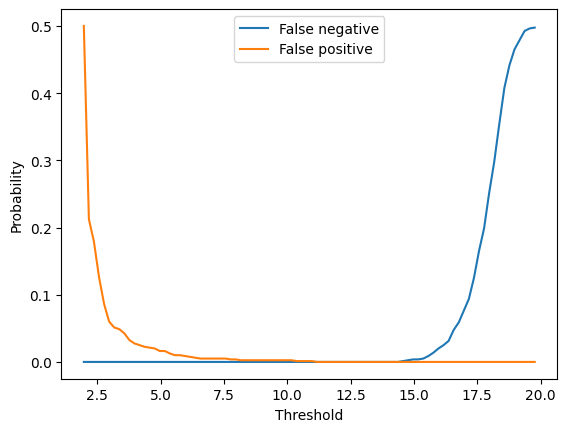

In [27]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [28]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,50,1024,1)
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]): ## mean+sdtv of the normal matrixes
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==labels_test

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.4888


  0%|          | 2/800 [00:00<01:09, 11.55it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.8175


  0%|          | 4/800 [00:00<01:07, 11.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 3.8620


  1%|          | 6/800 [00:00<01:08, 11.65it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.2740


  1%|          | 8/800 [00:00<01:04, 12.22it/s]

1/1 [==============================] - 0s 39ms/step - loss: 17.8172


  1%|▏         | 10/800 [00:00<01:06, 11.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.6075


  2%|▏         | 12/800 [00:00<01:02, 12.58it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1450


  2%|▏         | 14/800 [00:01<01:01, 12.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.1833


  2%|▏         | 16/800 [00:01<01:02, 12.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1479


  2%|▏         | 18/800 [00:01<01:01, 12.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5762


  2%|▎         | 20/800 [00:01<01:00, 12.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5499


  3%|▎         | 22/800 [00:01<00:58, 13.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1166


  3%|▎         | 24/800 [00:01<00:59, 12.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1025


  3%|▎         | 26/800 [00:02<00:55, 13.84it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1348


  4%|▎         | 28/800 [00:02<00:55, 13.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1544


  4%|▍         | 30/800 [00:02<00:58, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0906


  4%|▍         | 32/800 [00:02<00:59, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.6318


  4%|▍         | 34/800 [00:02<00:58, 13.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5586


  4%|▍         | 36/800 [00:02<00:57, 13.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.5710


  5%|▍         | 38/800 [00:02<00:56, 13.48it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0718


  5%|▌         | 40/800 [00:03<00:55, 13.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.8620


  5%|▌         | 42/800 [00:03<00:54, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.7003


  6%|▌         | 44/800 [00:03<00:54, 13.77it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5139


  6%|▌         | 46/800 [00:03<00:55, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 14.8228


  6%|▌         | 48/800 [00:03<00:53, 13.99it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1009


  6%|▋         | 50/800 [00:03<00:54, 13.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0850


  6%|▋         | 52/800 [00:03<00:52, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.4383


  7%|▋         | 54/800 [00:04<00:52, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.5594


  7%|▋         | 56/800 [00:04<00:50, 14.62it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.1157


  7%|▋         | 58/800 [00:04<00:58, 12.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1366


  8%|▊         | 60/800 [00:04<00:57, 12.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0431


  8%|▊         | 62/800 [00:04<00:56, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.9113


  8%|▊         | 64/800 [00:04<00:54, 13.59it/s]

1/1 [==============================] - 0s 52ms/step - loss: 16.8382


  8%|▊         | 66/800 [00:05<01:00, 12.22it/s]

1/1 [==============================] - 0s 42ms/step - loss: 17.3659


  8%|▊         | 68/800 [00:05<01:03, 11.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.0357


  9%|▉         | 70/800 [00:05<01:06, 11.04it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1355


  9%|▉         | 72/800 [00:05<01:07, 10.73it/s]

1/1 [==============================] - 0s 44ms/step - loss: 18.5135


  9%|▉         | 74/800 [00:05<01:10, 10.30it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.8571


 10%|▉         | 76/800 [00:06<01:11, 10.07it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.6113


 10%|▉         | 78/800 [00:06<01:11, 10.05it/s]

1/1 [==============================] - 0s 44ms/step - loss: 17.7425


 10%|█         | 80/800 [00:06<01:10, 10.16it/s]

1/1 [==============================] - 0s 42ms/step - loss: 17.5158


 10%|█         | 82/800 [00:06<01:11, 10.11it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.7606


 10%|█         | 84/800 [00:06<01:12,  9.90it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1233


 11%|█         | 86/800 [00:07<01:11, 10.05it/s]

1/1 [==============================] - 0s 48ms/step - loss: 16.5300


 11%|█         | 88/800 [00:07<01:11, 10.01it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.8309


 11%|█▏        | 90/800 [00:07<01:10, 10.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4043


 12%|█▏        | 92/800 [00:07<01:02, 11.27it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.7635


 12%|█▏        | 94/800 [00:07<00:59, 11.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.3233


 12%|█▏        | 96/800 [00:07<00:57, 12.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.6212


 12%|█▏        | 98/800 [00:08<00:56, 12.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1438


 12%|█▎        | 100/800 [00:08<00:55, 12.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.2450


 13%|█▎        | 102/800 [00:08<00:55, 12.67it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.8005


 13%|█▎        | 104/800 [00:08<00:53, 12.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.8031


 13%|█▎        | 106/800 [00:08<00:52, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.2017


 14%|█▎        | 108/800 [00:08<00:50, 13.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.4640


 14%|█▍        | 110/800 [00:08<00:50, 13.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.7409


 14%|█▍        | 112/800 [00:09<00:48, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1168


 14%|█▍        | 114/800 [00:09<00:47, 14.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.2466


 14%|█▍        | 116/800 [00:09<00:47, 14.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.6150


 15%|█▍        | 118/800 [00:09<00:47, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1993


 15%|█▌        | 120/800 [00:09<00:46, 14.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 15.8767


 15%|█▌        | 122/800 [00:09<00:45, 15.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.8283


 16%|█▌        | 124/800 [00:09<00:45, 14.91it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.3751


 16%|█▌        | 126/800 [00:09<00:47, 14.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1135


 16%|█▌        | 128/800 [00:10<00:47, 14.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4866


 16%|█▋        | 130/800 [00:10<00:48, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.9281


 16%|█▋        | 132/800 [00:10<00:49, 13.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0929


 17%|█▋        | 134/800 [00:10<00:49, 13.41it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1492


 17%|█▋        | 136/800 [00:10<00:50, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8620


 17%|█▋        | 138/800 [00:10<00:49, 13.30it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1179


 18%|█▊        | 140/800 [00:11<00:49, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1030


 18%|█▊        | 142/800 [00:11<00:50, 13.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1003


 18%|█▊        | 144/800 [00:11<00:49, 13.19it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.5796


 18%|█▊        | 146/800 [00:11<00:48, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.4169


 18%|█▊        | 148/800 [00:11<00:48, 13.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.2699


 19%|█▉        | 150/800 [00:11<00:49, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1112


 19%|█▉        | 152/800 [00:11<00:49, 13.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.5039


 19%|█▉        | 154/800 [00:12<00:48, 13.33it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.9481


 20%|█▉        | 156/800 [00:12<00:47, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.5338


 20%|█▉        | 158/800 [00:12<00:44, 14.29it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.2722


 20%|██        | 160/800 [00:12<00:46, 13.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.5078


 20%|██        | 162/800 [00:12<00:44, 14.26it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1382


 20%|██        | 164/800 [00:12<00:44, 14.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1155


 21%|██        | 166/800 [00:12<00:44, 14.15it/s]

1/1 [==============================] - 0s 30ms/step - loss: 1.9990


 21%|██        | 168/800 [00:13<00:45, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.0821


 21%|██▏       | 170/800 [00:13<00:44, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.4392


 22%|██▏       | 172/800 [00:13<00:45, 13.76it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1421


 22%|██▏       | 174/800 [00:13<00:46, 13.37it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.3646


 22%|██▏       | 176/800 [00:13<00:48, 12.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.9523


 22%|██▏       | 178/800 [00:13<00:47, 13.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.7941


 22%|██▎       | 180/800 [00:14<00:45, 13.53it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.5135


 23%|██▎       | 182/800 [00:14<00:43, 14.07it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1057


 23%|██▎       | 184/800 [00:14<00:43, 14.02it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1074


 23%|██▎       | 186/800 [00:14<00:44, 13.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.4629


 24%|██▎       | 188/800 [00:14<00:43, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.1753


 24%|██▍       | 190/800 [00:14<00:42, 14.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.4765


 24%|██▍       | 192/800 [00:14<00:43, 14.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 1.9990


 24%|██▍       | 194/800 [00:15<00:44, 13.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1476


 24%|██▍       | 196/800 [00:15<00:45, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9444


 25%|██▍       | 198/800 [00:15<00:45, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.5827


 25%|██▌       | 200/800 [00:15<00:45, 13.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.3920


 25%|██▌       | 202/800 [00:15<00:46, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.5263


 26%|██▌       | 204/800 [00:15<00:46, 12.87it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5095


 26%|██▌       | 206/800 [00:15<00:46, 12.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.5453


 26%|██▌       | 208/800 [00:16<00:44, 13.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.1266


 26%|██▋       | 210/800 [00:16<00:44, 13.40it/s]

1/1 [==============================] - 0s 32ms/step - loss: 19.9265


 26%|██▋       | 212/800 [00:16<00:44, 13.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1425


 27%|██▋       | 214/800 [00:16<00:44, 13.24it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.1232


 27%|██▋       | 216/800 [00:16<00:45, 12.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.7810


 27%|██▋       | 218/800 [00:16<00:43, 13.34it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.7433


 28%|██▊       | 220/800 [00:17<00:46, 12.46it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.9132


 28%|██▊       | 222/800 [00:17<00:44, 12.88it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.1210


 28%|██▊       | 224/800 [00:17<00:44, 12.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 4.8244


 28%|██▊       | 226/800 [00:17<00:45, 12.70it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.2889


 28%|██▊       | 228/800 [00:17<00:49, 11.57it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.1978


 29%|██▉       | 230/800 [00:17<00:51, 11.06it/s]

1/1 [==============================] - 0s 40ms/step - loss: 17.1797


 29%|██▉       | 232/800 [00:18<00:52, 10.88it/s]

1/1 [==============================] - 0s 38ms/step - loss: 15.2288


 29%|██▉       | 234/800 [00:18<00:52, 10.70it/s]

1/1 [==============================] - 0s 38ms/step - loss: 18.3867


 30%|██▉       | 236/800 [00:18<00:57,  9.89it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0963


 30%|██▉       | 238/800 [00:18<00:55, 10.12it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.4301


 30%|███       | 240/800 [00:18<00:53, 10.38it/s]

1/1 [==============================] - 0s 31ms/step - loss: 19.3030


 30%|███       | 242/800 [00:19<00:52, 10.69it/s]

1/1 [==============================] - 0s 32ms/step - loss: 10.3368


 30%|███       | 244/800 [00:19<00:50, 10.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.2359


 31%|███       | 246/800 [00:19<00:52, 10.62it/s]

1/1 [==============================] - 0s 46ms/step - loss: 4.6184


 31%|███       | 248/800 [00:19<00:53, 10.39it/s]

1/1 [==============================] - 0s 41ms/step - loss: 17.0298


 31%|███▏      | 250/800 [00:19<00:53, 10.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.5269


 32%|███▏      | 252/800 [00:19<00:49, 11.01it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.6504


 32%|███▏      | 254/800 [00:20<00:47, 11.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.0390


 32%|███▏      | 256/800 [00:20<00:45, 11.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3775


 32%|███▏      | 258/800 [00:20<00:43, 12.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8509


 32%|███▎      | 260/800 [00:20<00:41, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.4453


 33%|███▎      | 262/800 [00:20<00:42, 12.51it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.1293


 33%|███▎      | 264/800 [00:20<00:42, 12.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1069


 33%|███▎      | 266/800 [00:21<00:40, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 15.5441


 34%|███▎      | 268/800 [00:21<00:38, 13.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.7996


 34%|███▍      | 270/800 [00:21<00:39, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1528


 34%|███▍      | 272/800 [00:21<00:39, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.2007


 34%|███▍      | 274/800 [00:21<00:38, 13.65it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.4524


 34%|███▍      | 276/800 [00:21<00:38, 13.48it/s]

1/1 [==============================] - 0s 30ms/step - loss: 15.8675


 35%|███▍      | 278/800 [00:21<00:38, 13.60it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.3407


 35%|███▌      | 280/800 [00:22<00:37, 13.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.2857


 35%|███▌      | 282/800 [00:22<00:36, 14.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.8927


 36%|███▌      | 284/800 [00:22<00:36, 14.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.0494


 36%|███▌      | 286/800 [00:22<00:36, 14.05it/s]

1/1 [==============================] - 0s 32ms/step - loss: 16.8080


 36%|███▌      | 288/800 [00:22<00:38, 13.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1377


 36%|███▋      | 290/800 [00:22<00:37, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0196


 36%|███▋      | 292/800 [00:22<00:36, 13.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.9263


 37%|███▋      | 294/800 [00:23<00:35, 14.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 17.2713


 37%|███▋      | 296/800 [00:23<00:36, 13.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0095


 37%|███▋      | 298/800 [00:23<00:35, 14.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.8788


 38%|███▊      | 300/800 [00:23<00:35, 14.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.1336


 38%|███▊      | 302/800 [00:23<00:35, 13.98it/s]

1/1 [==============================] - 0s 37ms/step - loss: 5.4703


 38%|███▊      | 304/800 [00:23<00:35, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.7714


 38%|███▊      | 306/800 [00:23<00:36, 13.56it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1350


 38%|███▊      | 308/800 [00:24<00:36, 13.50it/s]

1/1 [==============================] - 0s 27ms/step - loss: 1.9852


 39%|███▉      | 310/800 [00:24<00:36, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0692


 39%|███▉      | 312/800 [00:24<00:36, 13.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1229


 39%|███▉      | 314/800 [00:24<00:36, 13.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1065


 40%|███▉      | 316/800 [00:24<00:36, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.2267


 40%|███▉      | 318/800 [00:24<00:35, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4319


 40%|████      | 320/800 [00:24<00:34, 14.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1352


 40%|████      | 322/800 [00:25<00:34, 13.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.5862


 40%|████      | 324/800 [00:25<00:33, 14.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6203


 41%|████      | 326/800 [00:25<00:34, 13.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.0289


 41%|████      | 328/800 [00:25<00:35, 13.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 16.8009


 41%|████▏     | 330/800 [00:25<00:35, 13.25it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1664


 42%|████▏     | 332/800 [00:25<00:36, 12.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1199


 42%|████▏     | 334/800 [00:26<00:35, 12.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.1832


 42%|████▏     | 336/800 [00:26<00:34, 13.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.3047


 42%|████▏     | 338/800 [00:26<00:33, 13.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.2240


 42%|████▎     | 340/800 [00:26<00:33, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.7899


 43%|████▎     | 342/800 [00:26<00:33, 13.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.9121


 43%|████▎     | 344/800 [00:26<00:32, 13.84it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1030


 43%|████▎     | 346/800 [00:26<00:35, 12.63it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.7365


 44%|████▎     | 348/800 [00:27<00:35, 12.79it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.8353


 44%|████▍     | 350/800 [00:27<00:35, 12.63it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.5306


 44%|████▍     | 352/800 [00:27<00:34, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1077


 44%|████▍     | 354/800 [00:27<00:34, 12.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1079


 44%|████▍     | 356/800 [00:27<00:34, 13.02it/s]

1/1 [==============================] - 0s 34ms/step - loss: 17.8803


 45%|████▍     | 358/800 [00:27<00:33, 13.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.4896


 45%|████▌     | 360/800 [00:27<00:33, 13.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.5947


 45%|████▌     | 362/800 [00:28<00:33, 12.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.1226


 46%|████▌     | 364/800 [00:28<00:32, 13.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.4275


 46%|████▌     | 366/800 [00:28<00:32, 13.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.5630


 46%|████▌     | 368/800 [00:28<00:31, 13.70it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.4055


 46%|████▋     | 370/800 [00:28<00:31, 13.44it/s]

1/1 [==============================] - 0s 36ms/step - loss: 17.3718


 46%|████▋     | 372/800 [00:28<00:31, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0965


 47%|████▋     | 374/800 [00:29<00:31, 13.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.7687


 47%|████▋     | 376/800 [00:29<00:31, 13.67it/s]

1/1 [==============================] - 0s 28ms/step - loss: 16.4157


 47%|████▋     | 378/800 [00:29<00:31, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.0441


 48%|████▊     | 380/800 [00:29<00:30, 13.61it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.1375


 48%|████▊     | 382/800 [00:29<00:31, 13.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.9421


 48%|████▊     | 384/800 [00:29<00:32, 12.72it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1017


 48%|████▊     | 386/800 [00:30<00:35, 11.70it/s]

1/1 [==============================] - 0s 38ms/step - loss: 17.8077


 48%|████▊     | 388/800 [00:30<00:37, 10.97it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.6727


 49%|████▉     | 390/800 [00:30<00:38, 10.69it/s]

1/1 [==============================] - 0s 38ms/step - loss: 18.3313


 49%|████▉     | 392/800 [00:30<00:38, 10.70it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1094


 49%|████▉     | 394/800 [00:30<00:38, 10.49it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1015


 50%|████▉     | 396/800 [00:31<00:39, 10.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.7454


 50%|████▉     | 398/800 [00:31<00:38, 10.42it/s]

1/1 [==============================] - 0s 42ms/step - loss: 16.5427


 50%|█████     | 400/800 [00:31<00:38, 10.39it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1440


 50%|█████     | 402/800 [00:31<00:38, 10.42it/s]

1/1 [==============================] - 0s 40ms/step - loss: 2.1001


 50%|█████     | 404/800 [00:31<00:38, 10.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.6011


 51%|█████     | 406/800 [00:31<00:37, 10.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1141


 51%|█████     | 408/800 [00:32<00:38, 10.24it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1122


 51%|█████▏    | 410/800 [00:32<00:37, 10.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 4.8431


 52%|█████▏    | 412/800 [00:32<00:35, 10.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.1799


 52%|█████▏    | 414/800 [00:32<00:32, 11.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 5.8950


 52%|█████▏    | 416/800 [00:32<00:31, 12.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1260


 52%|█████▏    | 418/800 [00:32<00:30, 12.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 18.9643


 52%|█████▎    | 420/800 [00:33<00:29, 12.89it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.9166


 53%|█████▎    | 422/800 [00:33<00:28, 13.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 2.0215


 53%|█████▎    | 424/800 [00:33<00:28, 13.36it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.7035


 53%|█████▎    | 426/800 [00:33<00:27, 13.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1484


 54%|█████▎    | 428/800 [00:33<00:27, 13.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.2703


 54%|█████▍    | 430/800 [00:33<00:27, 13.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.7858


 54%|█████▍    | 432/800 [00:33<00:27, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0936


 54%|█████▍    | 434/800 [00:34<00:26, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.3371


 55%|█████▍    | 436/800 [00:34<00:26, 13.54it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.0916


 55%|█████▍    | 438/800 [00:34<00:25, 14.10it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.6434


 55%|█████▌    | 440/800 [00:34<00:26, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.7963


 55%|█████▌    | 442/800 [00:34<00:26, 13.38it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.8024


 56%|█████▌    | 444/800 [00:34<00:26, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.6587


 56%|█████▌    | 446/800 [00:34<00:26, 13.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0568


 56%|█████▌    | 448/800 [00:35<00:25, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.8064


 56%|█████▋    | 450/800 [00:35<00:25, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 16.4412


 56%|█████▋    | 452/800 [00:35<00:25, 13.65it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.3225


 57%|█████▋    | 454/800 [00:35<00:25, 13.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0861


 57%|█████▋    | 456/800 [00:35<00:25, 13.47it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.8805


 57%|█████▋    | 458/800 [00:35<00:25, 13.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.6663


 57%|█████▊    | 460/800 [00:36<00:26, 13.05it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1113


 58%|█████▊    | 462/800 [00:36<00:26, 12.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1840


 58%|█████▊    | 464/800 [00:36<00:25, 13.11it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.4906


 58%|█████▊    | 466/800 [00:36<00:25, 13.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0445


 58%|█████▊    | 468/800 [00:36<00:25, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0731


 59%|█████▉    | 470/800 [00:36<00:25, 12.79it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.6887


 59%|█████▉    | 472/800 [00:36<00:25, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.8360


 59%|█████▉    | 474/800 [00:37<00:25, 12.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.8734


 60%|█████▉    | 476/800 [00:37<00:24, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1384


 60%|█████▉    | 478/800 [00:37<00:24, 13.01it/s]

1/1 [==============================] - 0s 35ms/step - loss: 17.5822


 60%|██████    | 480/800 [00:37<00:24, 13.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.9928


 60%|██████    | 482/800 [00:37<00:24, 13.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.3913


 60%|██████    | 484/800 [00:37<00:24, 13.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.3965


 61%|██████    | 486/800 [00:38<00:23, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0498


 61%|██████    | 488/800 [00:38<00:23, 13.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1144


 61%|██████▏   | 490/800 [00:38<00:22, 13.49it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1147


 62%|██████▏   | 492/800 [00:38<00:22, 13.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 19.2066


 62%|██████▏   | 494/800 [00:38<00:23, 13.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.2626


 62%|██████▏   | 496/800 [00:38<00:22, 13.29it/s]

1/1 [==============================] - 0s 28ms/step - loss: 15.4907


 62%|██████▏   | 498/800 [00:38<00:22, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.5807


 62%|██████▎   | 500/800 [00:39<00:22, 13.47it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1458


 63%|██████▎   | 502/800 [00:39<00:22, 13.06it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.4213


 63%|██████▎   | 504/800 [00:39<00:22, 13.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.8220


 63%|██████▎   | 506/800 [00:39<00:22, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.1874


 64%|██████▎   | 508/800 [00:39<00:21, 13.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.7132


 64%|██████▍   | 510/800 [00:39<00:20, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 3.5952


 64%|██████▍   | 512/800 [00:39<00:20, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.3400


 64%|██████▍   | 514/800 [00:40<00:20, 13.97it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.8859


 64%|██████▍   | 516/800 [00:40<00:20, 13.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.5260


 65%|██████▍   | 518/800 [00:40<00:20, 13.70it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0850


 65%|██████▌   | 520/800 [00:40<00:20, 13.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.3395


 65%|██████▌   | 522/800 [00:40<00:20, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.7869


 66%|██████▌   | 524/800 [00:40<00:20, 13.19it/s]

1/1 [==============================] - 0s 29ms/step - loss: 3.9248


 66%|██████▌   | 526/800 [00:40<00:20, 13.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 2.0221


 66%|██████▌   | 528/800 [00:41<00:20, 13.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.4630


 66%|██████▋   | 530/800 [00:41<00:20, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 19.7748


 66%|██████▋   | 532/800 [00:41<00:19, 13.83it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1263


 67%|██████▋   | 534/800 [00:41<00:19, 13.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1567


 67%|██████▋   | 536/800 [00:41<00:19, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 3.1651


 67%|██████▋   | 538/800 [00:41<00:19, 13.77it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1422


 68%|██████▊   | 540/800 [00:42<00:18, 13.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 16.5554


 68%|██████▊   | 542/800 [00:42<00:18, 13.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.2807


 68%|██████▊   | 544/800 [00:42<00:18, 13.70it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1434


 68%|██████▊   | 546/800 [00:42<00:19, 13.26it/s]

1/1 [==============================] - 0s 39ms/step - loss: 18.8578


 68%|██████▊   | 548/800 [00:42<00:20, 12.04it/s]

1/1 [==============================] - 0s 41ms/step - loss: 2.4646


 69%|██████▉   | 550/800 [00:42<00:22, 11.28it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.0655


 69%|██████▉   | 552/800 [00:43<00:23, 10.72it/s]

1/1 [==============================] - 0s 43ms/step - loss: 17.6528


 69%|██████▉   | 554/800 [00:43<00:24, 10.23it/s]

1/1 [==============================] - 0s 37ms/step - loss: 17.5589


 70%|██████▉   | 556/800 [00:43<00:23, 10.21it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.1382


 70%|██████▉   | 558/800 [00:43<00:23, 10.49it/s]

1/1 [==============================] - 0s 40ms/step - loss: 6.3750


 70%|███████   | 560/800 [00:43<00:23, 10.08it/s]

1/1 [==============================] - 0s 33ms/step - loss: 17.3301


 70%|███████   | 562/800 [00:44<00:23, 10.34it/s]

1/1 [==============================] - 0s 45ms/step - loss: 2.3775


 70%|███████   | 564/800 [00:44<00:23,  9.87it/s]

1/1 [==============================] - 0s 52ms/step - loss: 2.1394


 71%|███████   | 565/800 [00:44<00:24,  9.44it/s]

1/1 [==============================] - 0s 37ms/step - loss: 18.0380


 71%|███████   | 566/800 [00:44<00:24,  9.45it/s]

1/1 [==============================] - 0s 47ms/step - loss: 2.1176


 71%|███████   | 567/800 [00:44<00:27,  8.61it/s]

1/1 [==============================] - 0s 37ms/step - loss: 15.9426


 71%|███████   | 568/800 [00:44<00:26,  8.86it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.5440


 71%|███████   | 569/800 [00:44<00:25,  8.91it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.3097


 71%|███████▏  | 570/800 [00:44<00:25,  9.17it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0812


 71%|███████▏  | 571/800 [00:45<00:24,  9.22it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.1650


 72%|███████▏  | 573/800 [00:45<00:21, 10.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.7056


 72%|███████▏  | 575/800 [00:45<00:19, 11.35it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.2145


 72%|███████▏  | 577/800 [00:45<00:18, 12.11it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.5530


 72%|███████▏  | 579/800 [00:45<00:17, 12.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.4615


 73%|███████▎  | 581/800 [00:45<00:16, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1047


 73%|███████▎  | 583/800 [00:45<00:16, 13.37it/s]

1/1 [==============================] - 0s 22ms/step - loss: 2.5794


 73%|███████▎  | 585/800 [00:46<00:15, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1122


 73%|███████▎  | 587/800 [00:46<00:15, 14.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1330


 74%|███████▎  | 589/800 [00:46<00:15, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.1164


 74%|███████▍  | 591/800 [00:46<00:15, 13.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3928


 74%|███████▍  | 593/800 [00:46<00:16, 12.64it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1371


 74%|███████▍  | 595/800 [00:46<00:16, 12.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.3157


 75%|███████▍  | 597/800 [00:47<00:16, 12.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1332


 75%|███████▍  | 599/800 [00:47<00:16, 12.52it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.5384


 75%|███████▌  | 601/800 [00:47<00:15, 12.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.1422


 75%|███████▌  | 603/800 [00:47<00:15, 12.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.4152


 76%|███████▌  | 605/800 [00:47<00:14, 13.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 19.2156


 76%|███████▌  | 607/800 [00:47<00:14, 13.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.1034


 76%|███████▌  | 609/800 [00:47<00:14, 13.12it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0942


 76%|███████▋  | 611/800 [00:48<00:14, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.9103


 77%|███████▋  | 613/800 [00:48<00:14, 12.87it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.3307


 77%|███████▋  | 615/800 [00:48<00:14, 12.87it/s]

1/1 [==============================] - 0s 28ms/step - loss: 18.4968


 77%|███████▋  | 617/800 [00:48<00:14, 12.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.0397


 77%|███████▋  | 619/800 [00:48<00:14, 12.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.7947


 78%|███████▊  | 621/800 [00:48<00:14, 12.57it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.5349


 78%|███████▊  | 623/800 [00:49<00:14, 12.44it/s]

1/1 [==============================] - 0s 24ms/step - loss: 16.4310


 78%|███████▊  | 625/800 [00:49<00:13, 12.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 3.2156


 78%|███████▊  | 627/800 [00:49<00:13, 13.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.4484


 79%|███████▊  | 629/800 [00:49<00:12, 13.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.1619


 79%|███████▉  | 631/800 [00:49<00:12, 13.34it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.0770


 79%|███████▉  | 633/800 [00:49<00:12, 13.51it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1231


 79%|███████▉  | 635/800 [00:49<00:12, 13.30it/s]

1/1 [==============================] - 0s 24ms/step - loss: 17.9658


 80%|███████▉  | 637/800 [00:50<00:11, 13.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 18.6113


 80%|███████▉  | 639/800 [00:50<00:12, 13.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.0902


 80%|████████  | 641/800 [00:50<00:11, 13.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.3248


 80%|████████  | 643/800 [00:50<00:11, 13.40it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.3835


 81%|████████  | 645/800 [00:50<00:11, 13.60it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4289


 81%|████████  | 647/800 [00:50<00:11, 13.29it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.0718


 81%|████████  | 649/800 [00:51<00:11, 12.87it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.2158


 81%|████████▏ | 651/800 [00:51<00:11, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1159


 82%|████████▏ | 653/800 [00:51<00:11, 12.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 17.3193


 82%|████████▏ | 655/800 [00:51<00:11, 12.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 16.1255


 82%|████████▏ | 657/800 [00:51<00:11, 12.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 16.8215


 82%|████████▏ | 659/800 [00:51<00:11, 12.38it/s]

1/1 [==============================] - 0s 34ms/step - loss: 19.3344


 83%|████████▎ | 661/800 [00:52<00:11, 12.31it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.9115


 83%|████████▎ | 663/800 [00:52<00:11, 12.31it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.1300


 83%|████████▎ | 665/800 [00:52<00:10, 12.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.1304


 83%|████████▎ | 667/800 [00:52<00:10, 12.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 16.9990


 84%|████████▎ | 669/800 [00:52<00:10, 12.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 17.0509


 84%|████████▍ | 671/800 [00:52<00:09, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.2351


 84%|████████▍ | 673/800 [00:52<00:09, 13.07it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0851


 84%|████████▍ | 675/800 [00:53<00:09, 12.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 18.1306


 85%|████████▍ | 677/800 [00:53<00:09, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 17.3427


 85%|████████▍ | 679/800 [00:53<00:09, 13.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0731


 85%|████████▌ | 681/800 [00:53<00:09, 12.66it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.3316


 85%|████████▌ | 683/800 [00:53<00:09, 12.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.0481


 86%|████████▌ | 685/800 [00:53<00:09, 12.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 4.4964


 86%|████████▌ | 687/800 [00:54<00:08, 13.01it/s]

1/1 [==============================] - 0s 27ms/step - loss: 15.9805


 86%|████████▌ | 689/800 [00:54<00:08, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3399


 86%|████████▋ | 691/800 [00:54<00:08, 13.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.1383


 87%|████████▋ | 693/800 [00:54<00:08, 13.14it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.7251


 87%|████████▋ | 695/800 [00:54<00:08, 13.06it/s]

1/1 [==============================] - 0s 31ms/step - loss: 3.4686


 87%|████████▋ | 697/800 [00:54<00:07, 13.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 17.0498


 87%|████████▋ | 699/800 [00:54<00:07, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1015


 88%|████████▊ | 701/800 [00:55<00:07, 13.01it/s]

1/1 [==============================] - 0s 38ms/step - loss: 6.0580


 88%|████████▊ | 703/800 [00:55<00:07, 12.30it/s]

1/1 [==============================] - 0s 35ms/step - loss: 18.0039


 88%|████████▊ | 705/800 [00:55<00:08, 11.58it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.0835


 88%|████████▊ | 707/800 [00:55<00:08, 11.11it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.1460


 89%|████████▊ | 709/800 [00:55<00:08, 10.48it/s]

1/1 [==============================] - 0s 38ms/step - loss: 2.0314


 89%|████████▉ | 711/800 [00:56<00:08, 10.21it/s]

1/1 [==============================] - 0s 34ms/step - loss: 18.5127


 89%|████████▉ | 713/800 [00:56<00:08, 10.23it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.1093


 89%|████████▉ | 715/800 [00:56<00:08,  9.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 4.8264


 90%|████████▉ | 717/800 [00:56<00:08,  9.73it/s]

1/1 [==============================] - 0s 46ms/step - loss: 2.1160


 90%|████████▉ | 718/800 [00:56<00:08,  9.56it/s]

1/1 [==============================] - 0s 37ms/step - loss: 2.2159


 90%|████████▉ | 719/800 [00:56<00:08,  9.48it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1271


 90%|█████████ | 720/800 [00:57<00:08,  9.36it/s]

1/1 [==============================] - 0s 40ms/step - loss: 15.4861


 90%|█████████ | 721/800 [00:57<00:08,  9.34it/s]

1/1 [==============================] - 0s 50ms/step - loss: 2.3645


 90%|█████████ | 723/800 [00:57<00:08,  9.34it/s]

1/1 [==============================] - 0s 36ms/step - loss: 18.6972


 90%|█████████ | 724/800 [00:57<00:08,  9.40it/s]

1/1 [==============================] - 0s 43ms/step - loss: 18.1847


 91%|█████████ | 725/800 [00:57<00:08,  9.35it/s]

1/1 [==============================] - 0s 36ms/step - loss: 2.1107


 91%|█████████ | 726/800 [00:57<00:07,  9.45it/s]

1/1 [==============================] - 0s 47ms/step - loss: 19.1560


 91%|█████████ | 727/800 [00:57<00:08,  8.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 3.6515


 91%|█████████ | 728/800 [00:57<00:07,  9.03it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.1082


 91%|█████████▏| 730/800 [00:58<00:07,  9.93it/s]

1/1 [==============================] - 0s 27ms/step - loss: 18.2481


 92%|█████████▏| 732/800 [00:58<00:06, 11.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 17.7703


 92%|█████████▏| 734/800 [00:58<00:05, 11.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 18.3087


 92%|█████████▏| 736/800 [00:58<00:05, 12.26it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1421


 92%|█████████▏| 738/800 [00:58<00:04, 12.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 18.5841


 92%|█████████▎| 740/800 [00:58<00:04, 12.69it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.0849


 93%|█████████▎| 742/800 [00:58<00:04, 12.77it/s]

1/1 [==============================] - 0s 26ms/step - loss: 3.6536


 93%|█████████▎| 744/800 [00:59<00:04, 12.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.1143


 93%|█████████▎| 746/800 [00:59<00:04, 12.92it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.2446


 94%|█████████▎| 748/800 [00:59<00:04, 11.88it/s]

1/1 [==============================] - 0s 39ms/step - loss: 2.5470


 94%|█████████▍| 750/800 [00:59<00:04, 11.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 18.0278


 94%|█████████▍| 752/800 [00:59<00:04, 11.92it/s]

1/1 [==============================] - 0s 36ms/step - loss: 16.6365


 94%|█████████▍| 754/800 [01:00<00:03, 11.85it/s]

1/1 [==============================] - 0s 28ms/step - loss: 2.0893


 94%|█████████▍| 756/800 [01:00<00:03, 12.29it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.1245


 95%|█████████▍| 758/800 [01:00<00:03, 12.60it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.1274


 95%|█████████▌| 760/800 [01:00<00:03, 12.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 2.4805


 95%|█████████▌| 762/800 [01:00<00:03, 12.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 18.4761


 96%|█████████▌| 764/800 [01:00<00:02, 12.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 16.9551


 96%|█████████▌| 766/800 [01:00<00:02, 12.64it/s]

1/1 [==============================] - 0s 35ms/step - loss: 2.1158


 96%|█████████▌| 768/800 [01:01<00:02, 11.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 18.4345


 96%|█████████▋| 770/800 [01:01<00:02, 11.96it/s]

1/1 [==============================] - 0s 32ms/step - loss: 2.2921


 96%|█████████▋| 772/800 [01:01<00:02, 12.16it/s]

1/1 [==============================] - 0s 31ms/step - loss: 2.8305


 97%|█████████▋| 774/800 [01:01<00:02, 12.42it/s]

1/1 [==============================] - 0s 25ms/step - loss: 18.0176


 97%|█████████▋| 776/800 [01:01<00:02, 11.89it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.2513


 97%|█████████▋| 778/800 [01:01<00:01, 12.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 2.1559


 98%|█████████▊| 780/800 [01:02<00:01, 12.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 14.6446


 98%|█████████▊| 782/800 [01:02<00:01, 12.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 2.6513


 98%|█████████▊| 784/800 [01:02<00:01, 12.80it/s]

1/1 [==============================] - 0s 30ms/step - loss: 2.0985


 98%|█████████▊| 786/800 [01:02<00:01, 12.73it/s]

1/1 [==============================] - 0s 32ms/step - loss: 17.8600


 98%|█████████▊| 788/800 [01:02<00:00, 12.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 2.4698


 99%|█████████▉| 790/800 [01:02<00:00, 13.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 17.3450


 99%|█████████▉| 792/800 [01:03<00:00, 12.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 2.3194


 99%|█████████▉| 794/800 [01:03<00:00, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 19.1303


100%|█████████▉| 796/800 [01:03<00:00, 12.91it/s]

1/1 [==============================] - 0s 33ms/step - loss: 2.0746


100%|█████████▉| 798/800 [01:03<00:00, 12.90it/s]

1/1 [==============================] - 0s 31ms/step - loss: 17.6153


100%|██████████| 800/800 [01:03<00:00, 12.57it/s]


In [29]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of our predictor 

The overall accuracy of the predictor is: 95.0 %


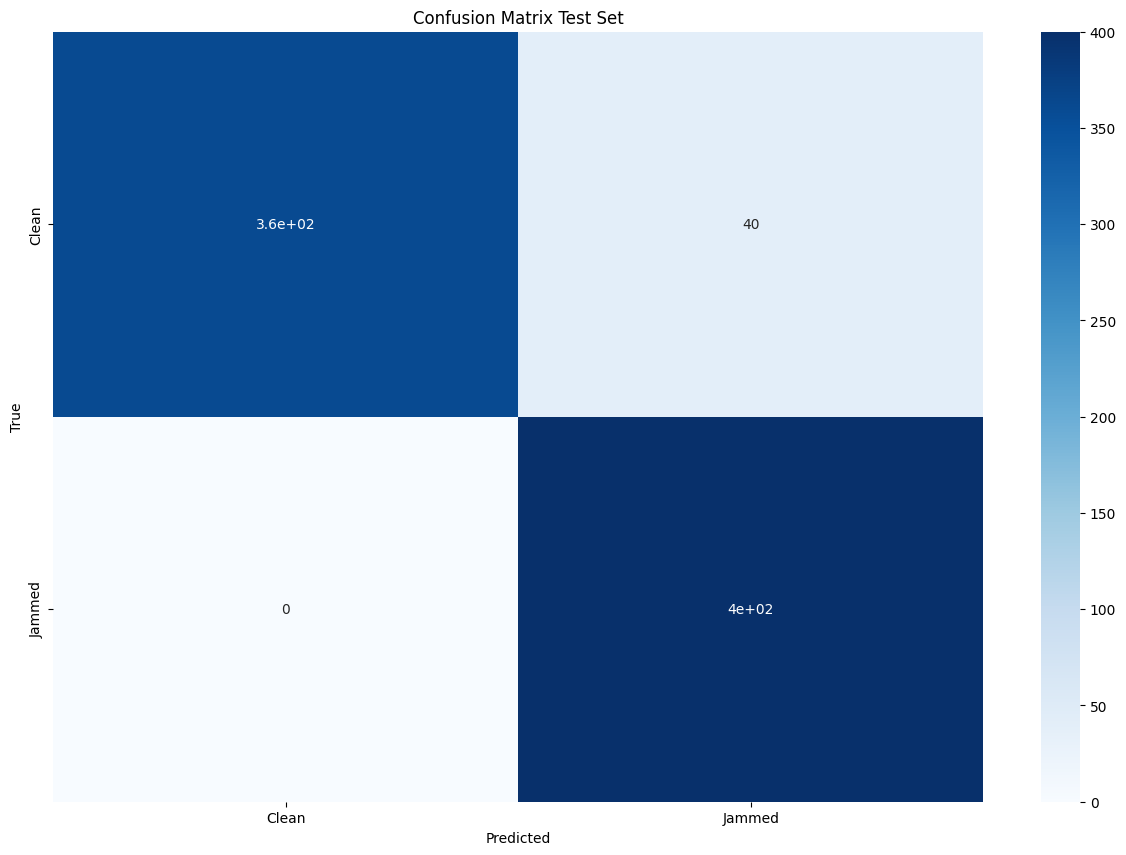

In [30]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold

In [36]:
def plot_heatmap(matrix, vmin=None, vmax=None):
    plt.imshow(matrix, cmap="coolwarm", vmin=vmin, vmax=vmax)
    ##plt.colorbar() i dont like the colorbar in the image
    plt.show()

In [32]:
num=random.randint(0,len(test))
original_matrix=test[num].reshape(1,50,1024,1) ## take the image
label_mat=labels_test[num] ## corresponding label
if(label_mat==0):
  print("The matrix is NOT an anomaly")
elif(label_mat==1):
  print("The matrix is an anomaly")


The matrix is an anomaly


1/1 [==============================] - 0s 29ms/step


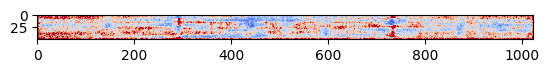

In [37]:
predicted_matrix=model.predict(original_matrix)
mse_mat=(original_matrix-predicted_matrix)**2 ##mse
plot_heatmap(mse_mat.reshape(50,1024),0,30)

In [38]:
num=random.randint(0,len(test))
original_matrix=test[num].reshape(1,50,1024,1) ## take the image
label_mat=labels_test[num] ## corresponding label
if(label_mat==0):
  print("The matrix is NOT an anomaly")
elif(label_mat==1):
  print("The matrix is an anomaly")


The matrix is NOT an anomaly


1/1 [==============================] - 0s 28ms/step


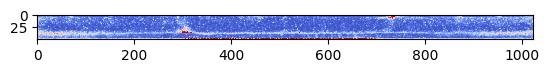

In [39]:
predicted_matrix=model.predict(original_matrix)
mse_mat=(original_matrix-predicted_matrix)**2 ##mse
plot_heatmap(mse_mat.reshape(50,1024),0,30)